# Recopilación Modelos de pronostico de precios:

## Simulacion de Montecarlo

In [ ]:
pip install pandas-montecarlo

In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas_montecarlo
import numpy as np
import pandas as pd

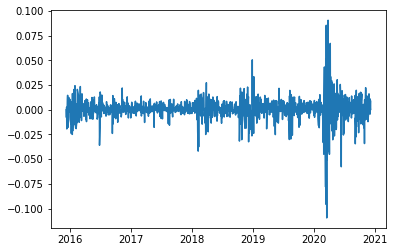

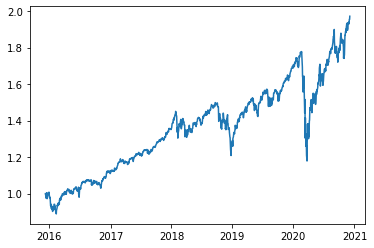

High         Low  ...  cum_return      balance
Date                                ...                         
2015-12-08  208.289993  205.779999  ...    1.000000  1000.000000
2015-12-09  208.679993  204.179993  ...    0.992220   992.220292
2015-12-10  207.429993  205.139999  ...    0.994781   994.781343
2015-12-11  204.139999  201.509995  ...    0.975501   975.501310
2015-12-14  203.050003  199.949997  ...    0.980430   980.429974
...                ...         ...  ...         ...          ...
2020-11-30  363.119995  359.170013  ...    1.930140  1930.139704
2020-12-01  367.679993  364.929993  ...    1.951250  1951.250395
2020-12-02  366.959991  364.200012  ...    1.955355  1955.355365
2020-12-03  368.190002  365.500000  ...    1.954822  1954.822233
2020-12-04  369.850006  367.220001  ...    1.971668  1971.668194

[1258 rows x 9 columns]

In [ ]:
balance = 1000

df = data.get_data_yahoo("SPY")
df['return'] = df['Adj Close'].pct_change().fillna(0)
df['cum_return'] = (df['return'] + 1).cumprod() 
df['balance'] = df['cum_return'] * balance

plt.plot(df['return'])
plt.show()
plt.plot(df['cum_return'])
plt.show()

df

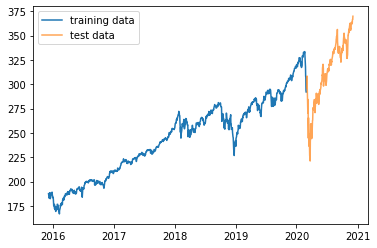

In [ ]:
#split data into train, and test
start_date = '2015'              
split_date = '2020-03'           #it could be only a year, 'year-month' or 'year-month-day'
train_data = df.loc[start_date : split_date[0:-1] + str(int(split_date[-1])-1)]
test_data = df.loc[split_date:]

#plotting price data
plt.plot(train_data['Adj Close'],label='training data')
plt.plot(test_data['Adj Close'],alpha=0.7,label='test data')
plt.legend()

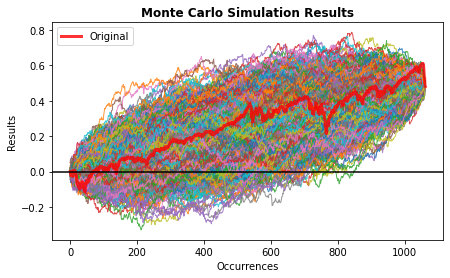

In [ ]:
n_sims = 1000

mc = train_data['return'].montecarlo(sims=n_sims)#, bust=-0.1, goal=1)
mc.plot(figsize=(7,4))

In [ ]:
mc_cum = (mc.data + 1).cumprod()
mc_cum

original         1         2  ...       997       998       999
0     1.000000  0.997008  0.998143  ...  0.994875  0.999086  1.006440
1     0.992220  0.997300  1.000870  ...  1.006861  0.979723  1.009967
2     0.994781  0.996833  0.998463  ...  1.015873  0.978263  1.010475
3     0.975501  1.004965  1.002502  ...  1.014525  0.973276  1.014188
4     0.980430  1.004072  0.994426  ...  1.015540  0.975091  1.015379
...        ...       ...       ...  ...       ...       ...       ...
1058  1.694501  1.560667  1.517976  ...  1.556868  1.551717  1.564694
1059  1.643154  1.559757  1.532445  ...  1.560442  1.560896  1.554577
1060  1.637111  1.558759  1.545706  ...  1.573272  1.542944  1.558042
1061  1.563585  1.559146  1.548580  ...  1.569323  1.548164  1.556212
1062  1.557016  1.557016  1.557016  ...  1.557016  1.557016  1.557016

[1063 rows x 1000 columns]

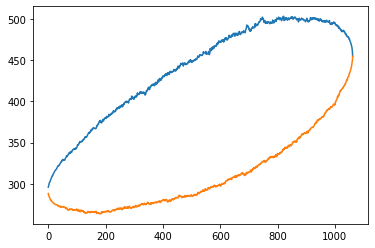

In [ ]:
n1 = len(train_data)
n2 = len(test_data)

a = 0.05

U = []  # Upper band
L = []  # Lower band

for i in range(n1):
  U.append((np.quantile(mc_cum.iloc[i],1-a))*train_data['Adj Close'].iloc[-1])
  L.append((np.quantile(mc_cum.iloc[i],a))*train_data['Adj Close'].iloc[-1])

plt.plot(U)
plt.plot(L)

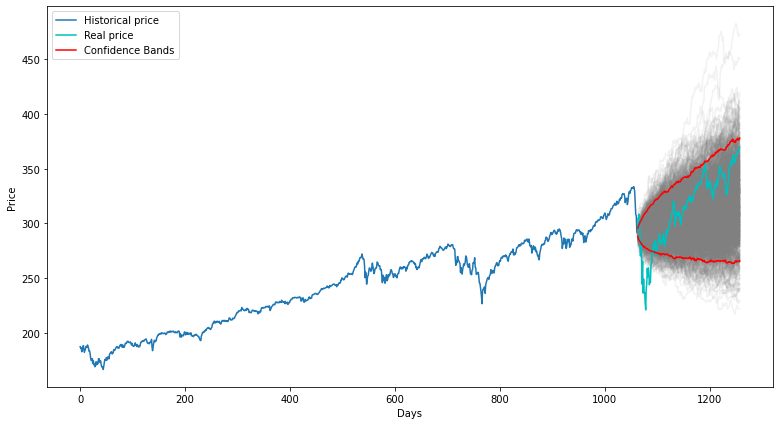

In [ ]:
plt.figure(figsize=(13,7))
plt.plot(train_data['Adj Close'].values, label='Historical price')
for i in range(1, n_sims):
    sim = (mc_cum[i] * train_data['Adj Close'].iloc[-1])[:n2]
    plt.plot(range(n1, n1+n2, 1), sim, '0.5', alpha=.1, color='gray')
plt.plot(range(n1, n1+n2, 1), test_data['Adj Close'].values, 'c', label="Real price")
plt.plot(range(n1, n1+n2, 1), U[:n2], 'r', label='Confidence Bands')
plt.plot(range(n1, n1+n2, 1), L[:n2], 'r')
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()

## Simulación Estocástica Euler-Maruyama
###Bandas de Confianza
#### Mateo Restrepo S

Bajo ciertas condiciones un conjunto de datos puede ser representado por
(Mirar pdf donde se específican bien cuales son):

$ dX_t = F(t)X_tdt + G(t)X_tdB_t, \quad X_{t_0} = X_0 $

Librerias usadas

In [ ]:
# Libraries
from yahoo_fin.stock_info import get_data
from matplotlib import pyplot as plt
import scipy
import numpy as np

Lectura de los datos

In [ ]:
# Extract data from yahoo finance: https://algotrading101.com/learn/yahoo-finance-api-guide/
dax_d = get_data("EWG", start_date="01/01/2016", end_date="01/01/2018",
                        index_as_date=True, interval="1d")

In [ ]:
print(dax_d)

                 open       high        low      close   adjclose    volume  \
2016-01-04  25.600000  25.629999  25.230000  25.559999  22.963259   5939400   
2016-01-05  25.309999  25.370001  25.090000  25.320000  22.747639   8073700   
2016-01-06  24.790001  25.090000  24.740000  25.030001  22.487103   7372800   
2016-01-07  24.530001  24.799999  24.469999  24.530001  22.037897  13044500   
2016-01-08  24.840000  24.870001  24.240000  24.290001  21.822279   6369000   
...               ...        ...        ...        ...        ...       ...   
2017-12-22  33.090000  33.110001  33.029999  33.099998  31.138823   8729400   
2017-12-26  33.160000  33.209999  33.060001  33.099998  31.138823   1160200   
2017-12-27  33.169998  33.250000  33.130001  33.180000  31.214085   1808600   
2017-12-28  33.279999  33.310001  33.119999  33.150002  31.185863   4310000   
2017-12-29  33.139999  33.169998  32.950001  33.020000  31.063560   2636900   

           ticker  
2016-01-04    EWG  
2016-01-05 

Para todos los calculos posteriores se utilizará el precio de cierre

In [ ]:
close_d1 = df.loc[:'2020-02']['Adj Close'].to_numpy()  # Data from year 1
n1 = len(close_d1)                                 # Number of days of year 1
close_d2 = df.loc['2020-03':]['Adj Close'].to_numpy()  # Data from year 2
n2 = len(close_d2)                                 # Number of days of year 2

Para este caso consideremos $F(t) = \mu$ y $G(t) = \sigma$ $\longrightarrow$ Parámetros constantes

Su estimación está dada por:

\begin{equation}
\hat{\mu}=\frac{\bar{R}_{i}}{\Delta t} \quad \hat{\sigma}=\sqrt{\frac{1}{\Delta t} \operatorname{Var}\left[R_{i}\right]}, \qquad donde\quad R_i = log\left(\frac{S_t}{S_{t-1}}\right)
\end{equation}

 Primero calculemos los retornos instantáneos

In [ ]:
# Instant Returns
def returns(data):
    dt_i = 1/n1                  # Delta_t
    R_i = []                     # Instant returns
    for i in range(1, n1):
        R_i.append(np.log(data[i] / data[i - 1]))
    return R_i, dt_i

R_i, dt_i = returns(close_d1)
print(R_i)

[-0.007810127795107127, 0.002577805733287523, -0.01957145398562219, 0.005039721575950384, 0.010443081637251371, 0.014525979218887217, -0.015355432222585801, -0.01797551278060324, 0.008215185602505115, 0.009033477038422586, 0.01230726574835907, -0.0016519222306446153, -0.0022873563112293907, 0.010615110333104796, -0.007112935429286327, -0.010053862215629253, -0.014078106161105745, 0.0016900181433575103, -0.01269455326502885, -0.024283752664985832, -0.011037428409532918, 0.0009896204835569673, 0.008035902774208487, -0.02525701972593583, 0.016283463920164932, -0.02169975673764841, 0.0013301528457850898, -0.012897831109947236, 0.005586441492213665, 0.0203076490159895, -0.015232031320244685, 0.013550741582302234, -0.010942633775951463, 0.005195543246150441, 0.02408502150737559, -0.0003615033845205767, -0.018186556696514162, 0.00597704272166144, 0.001567000093860516, -0.01923369047480312, -0.013552597930733637, 5.3789147637301096e-05, -0.0008630512379052538, -0.013093610226750338, 0.02040739

Ahora estimemos los parámetros

In [ ]:
def params(R, dt_i):
    mu = np.mean(R)/dt_i         # Drift
    s = np.sqrt(np.var(R)/dt_i)  # Variance
    return mu, s

mu, s = params(R_i, dt_i)
print(mu, s)

0.44318787980229885 0.2730748352727811


Para simular esto, se puede utilizar la aproximación de Euler-Maruyama (Ver Clase 11 diapositiva 5)

\begin{equation}
    X_{t_i} = X_{t_{i-1}} + \mu X_{t_{i-1}} \Delta t_i + \sigma X_{t_{i-1}} \Delta B_i
\end{equation}

In [ ]:
def sim(data, dt_i, mu, s, n_traj):
    xs_n = []
    for traj in range(1, n_traj+1):
        xs = [data[-1]]
        for i in range(1, n2):
            e = np.random.normal()
            dB_i = np.sqrt(dt_i)*e
            xs.append(xs[i-1] + mu*xs[i-1]*dt_i + s*xs[i-1]*dB_i)
        xs_n.append(xs)
    return xs_n

n_traj = 1000
xs_n = sim(close_d1, dt_i, mu, s, n_traj)

Veamos esto gráficamente que representa $\rightarrow$ Mostrar una y múltiples

Text(0, 0.5, 'Price')

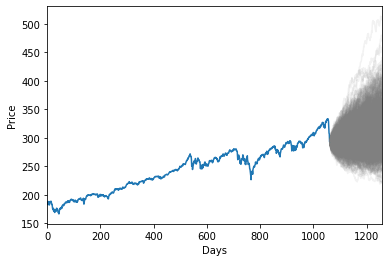

In [ ]:
plt.plot(close_d1)  # Plot the first year (Data use to forecast)
#plt.plot(range(n1, n1+n2, 1), xs_n[0]) # For one trajectory

# Multiple trajectories
for traj in range(n_traj-1):
    plt.gray()
    plt.plot(range(n1, n1+n2, 1), xs_n[traj], '0.5', alpha=.1)

plt.xlim([0, n1+n2])
plt.xlabel("Days")
plt.ylabel("Price")

Ahora calculemos las bandas de confianza

- Banda superior $\longrightarrow$ Cuantil $(1-\alpha)$ de los datos.
- Banda inferior $\longrightarrow$ Cuantil $\alpha$ de los datos

In [ ]:
def bands(xs_n, a):
    U = []  # Upper band
    L = []  # Lower band
    for t in range(n2):
        data_t = np.array([x[t] for x in xs_n])
        U.append(np.quantile(data_t, 1-a))
        L.append(np.quantile(data_t, a))
    return U, L

a = 0.05
U, L = bands(xs_n, a)

Veamos esto gráficamente

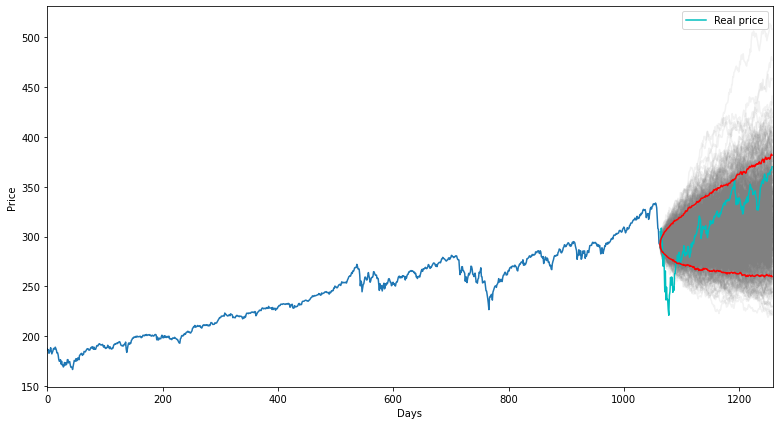

In [ ]:
plt.figure(figsize=(13,7))
plt.plot(close_d1)  # Plot the first year (Data use to forecast)
for traj in range(n_traj-1):
    plt.gray()
    plt.plot(range(n1, n1+n2, 1), xs_n[traj], '0.5', alpha=.1)

plt.plot(range(n1, n1+n2, 1), close_d2, 'c', label="Real price")
plt.plot(range(n1, n1+n2, 1), U, 'r')
plt.plot(range(n1, n1+n2, 1), L, 'r')
plt.xlim([0, n1+n2])
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()

## Montecarlo VS Euler-Maruyama

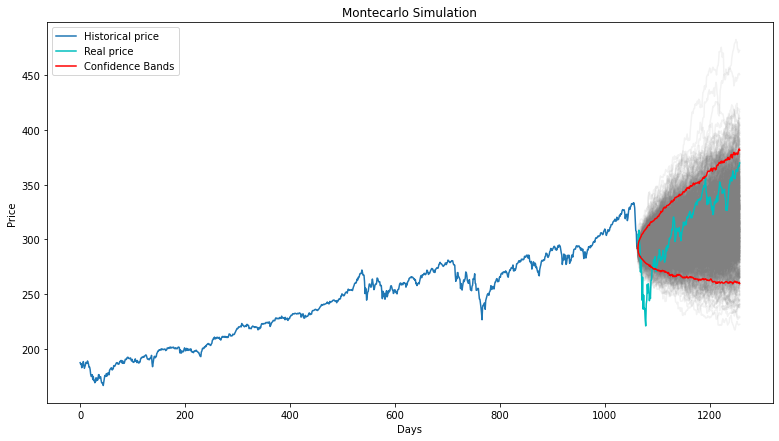

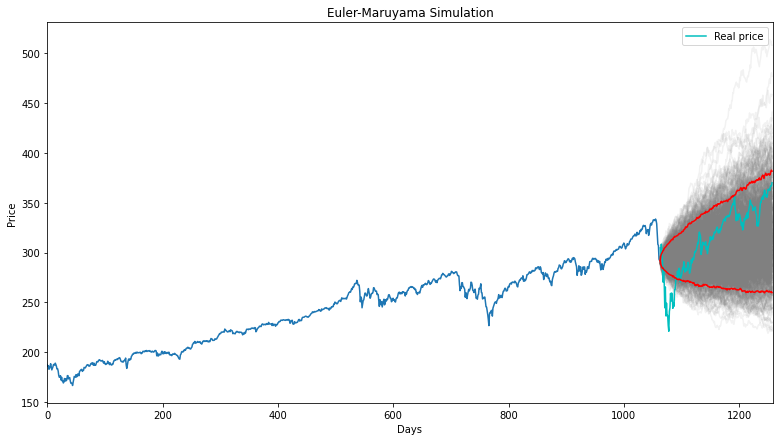

In [ ]:
plt.figure(figsize=(13,7))
plt.plot(train_data['Adj Close'].values, label='Historical price')
for i in range(1, n_sims):
    sim = (mc_cum[i] * train_data['Adj Close'].iloc[-1])[:n2]
    plt.plot(range(n1, n1+n2, 1), sim, '0.5', alpha=.1, color='gray')
plt.plot(range(n1, n1+n2, 1), test_data['Adj Close'].values, 'c', label="Real price")
plt.plot(range(n1, n1+n2, 1), U[:n2], 'r', label='Confidence Bands')
plt.plot(range(n1, n1+n2, 1), L[:n2], 'r')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title('Montecarlo Simulation')
plt.legend()
plt.show()



plt.figure(figsize=(13,7))
plt.plot(close_d1)  # Plot the first year (Data use to forecast)
for traj in range(n_traj-1):
    plt.gray()
    plt.plot(range(n1, n1+n2, 1), xs_n[traj], '0.5', alpha=.1)

plt.plot(range(n1, n1+n2, 1), close_d2, 'c', label="Real price")
plt.plot(range(n1, n1+n2, 1), U, 'r')
plt.plot(range(n1, n1+n2, 1), L, 'r')
plt.xlim([0, n1+n2])
plt.xlabel("Days")
plt.ylabel("Price")
plt.title('Euler-Maruyama Simulation')
plt.legend()
plt.show()

## fb Profet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import requests
import json
from pandas.io.json import json_normalize
from fbprophet import Prophet
import pandas_datareader.data as web

In [ ]:
def prophet(df,future=365, log=False):
  prices = df.copy()
  prices['y'] = prices.Close
  prices['ds'] = prices.index
  prices = prices[['ds', 'y']].reset_index()
  prices = prices[['ds', 'y']]
  if log == True:
    prices['y'] = np.log(prices['y'])
  #create a prophet model
  m = Prophet()
  m.fit(prices)
  #create a dataframe for the future
  future = m.make_future_dataframe(periods=future, freq='D')
  #create forecast
  forecast = m.predict(future)
  #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  #create plots
  fig1 = m.plot(forecast, figsize=(18,10))
  fig2 = m.plot_components(forecast)
  plt.show()
  return forecast

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


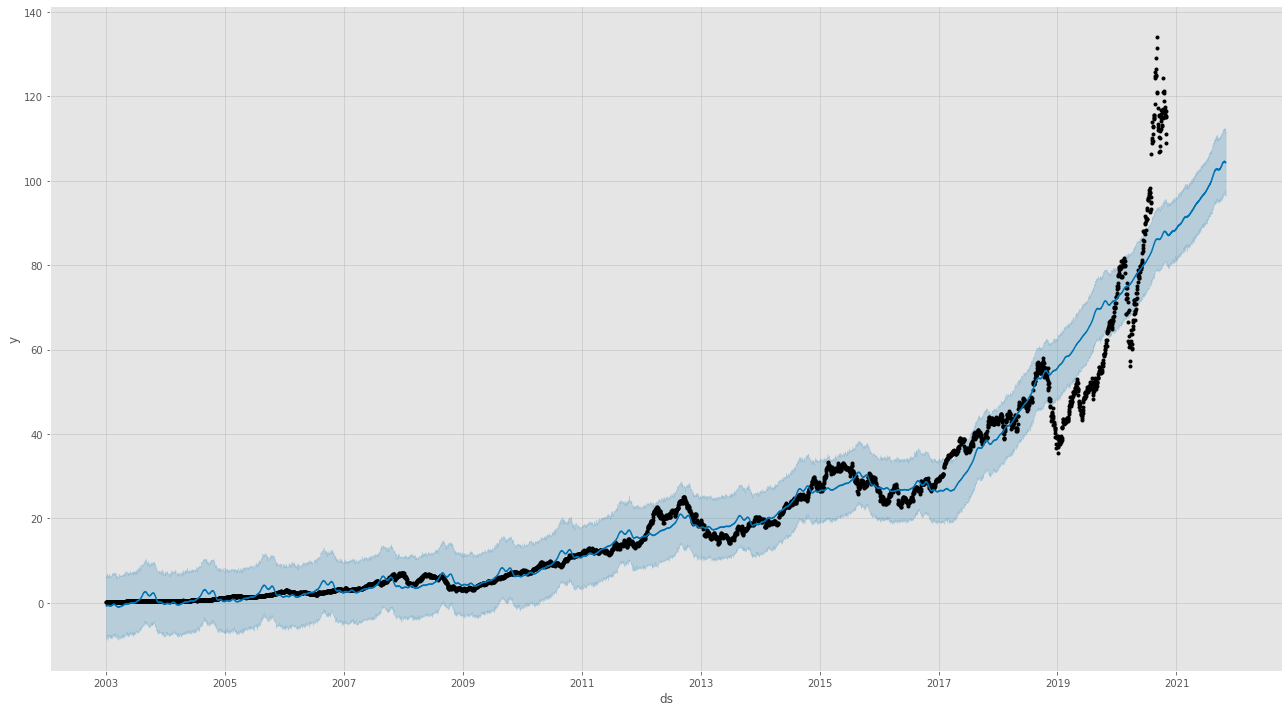

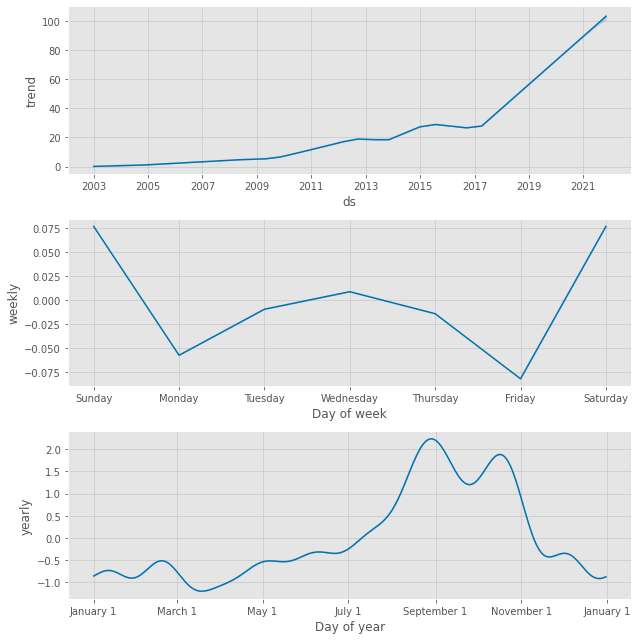

             ds       trend  ...  multiplicative_terms_upper        yhat
0    2003-01-02    0.111477  ...                         0.0   -0.747345
1    2003-01-03    0.112801  ...                         0.0   -0.796623
2    2003-01-06    0.116771  ...                         0.0   -0.718613
3    2003-01-07    0.118094  ...                         0.0   -0.655280
4    2003-01-08    0.119418  ...                         0.0   -0.623508
...         ...         ...  ...                         ...         ...
4850 2021-10-26  103.001375  ...                         0.0  104.470699
4851 2021-10-27  103.046549  ...                         0.0  104.446596
4852 2021-10-28  103.091723  ...                         0.0  104.374973
4853 2021-10-29  103.136897  ...                         0.0  104.253060
4854 2021-10-30  103.182070  ...                         0.0  104.352416

[4855 rows x 19 columns]


In [ ]:
df = web.DataReader('AAPL','yahoo', start='2003-01-01', end='2020-11-01')
forecast = prophet(df)
print(forecast)

##Predicción de acciones en la bolsa (tutorial redes LSTM)

link: https://youtu.be/3kXj6VgxbP8

In [ ]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
# Lectura de los datos
#
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2020, 11, 1)
dataset = web.DataReader('AAPL', 'yahoo', start, end)

#dataset['Close'] = np.log(dataset.Close)
dataset.head()

High       Low      Open     Close       Volume  Adj Close
Date                                                                      
2006-01-03  2.669643  2.580357  2.585000  2.669643  807234400.0   2.284267
2006-01-04  2.713571  2.660714  2.683214  2.677500  619603600.0   2.290990
2006-01-05  2.675000  2.633929  2.672500  2.656429  449422400.0   2.272961
2006-01-06  2.739286  2.662500  2.687500  2.725000  704457600.0   2.331634
2006-01-09  2.757143  2.705000  2.740357  2.716071  675040800.0   2.323994

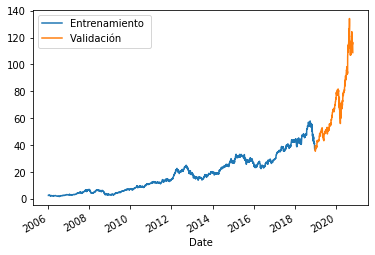

In [ ]:
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#
set_entrenamiento = dataset[:'2018'].iloc[:,0:5]
set_validacion = dataset['2019':].iloc[:,0:5]

set_entrenamiento['Close'].plot(legend=True)
set_validacion['Close'].plot(legend=True)
plt.legend(['Entrenamiento ', 'Validación '])
plt.show()

In [ ]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)


In [ ]:

# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 120
dias_pronostico = 20
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m-dias_pronostico):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i])
    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i+dias_pronostico-1])
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [ ]:
#Alternativa:


# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 100
dias_pronostico = 4
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m-dias_pronostico):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i:i+dias_pronostico,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
# Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
Y_train.shape

In [ ]:
# Reshape X_train para que se ajuste al modelo en Keras
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],X_train.shape[2], 1))

In [ ]:
# Red LSTM
#
dim_entrada = (X_train.shape[1],len(set_entrenamiento.columns))
dim_salida = Y_train.shape[1]
na = 50

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
3131/3131 [==============================] - 7s 2ms/step - loss: 0.0069
Epoch 2/20
3131/3131 [==============================] - 6s 2ms/step - loss: 0.0025
Epoch 3/20
3131/3131 [==============================] - 6s 2ms/step - loss: 0.0023
Epoch 4/20
3131/3131 [==============================] - 6s 2ms/step - loss: 0.0022
Epoch 5/20
3131/3131 [==============================] - 6s 2ms/step - loss: 0.0022
Epoch 6/20
3131/3131 [==============================] - 6s 2ms/step - loss: 0.0021
Epoch 7/20
3131/3131 [==============================] - 6s 2ms/step - loss: 0.0021
Epoch 8/20
3131/3131 [==============================] - 6s 2ms/step - loss: 0.0020
Epoch 9/20
3131/3131 [==============================] - 6s 2ms/step - loss: 0.0021
Epoch 10/20
3131/3131 [==============================] - 6s 2ms/step - loss: 0.0020
Epoch 11/20
3131/3131 [==============================] - 6s 2ms/step - loss: 0.0020
Epoch 12/20
3131/3131 [==============================] - 6s 2ms/step - loss: 0.0020
E

In [ ]:
# Validación (predicción del valor de las acciones)
#
x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i])
X_test = np.array(X_test)
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)


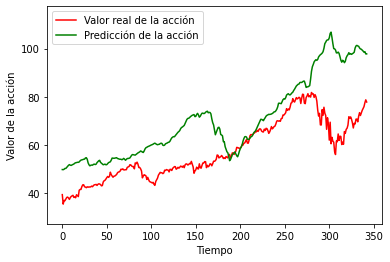

In [ ]:
# Funciones auxiliares
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='green', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

# Graficar resultados
graficar_predicciones(set_validacion.values[:,3],prediccion[:,3])

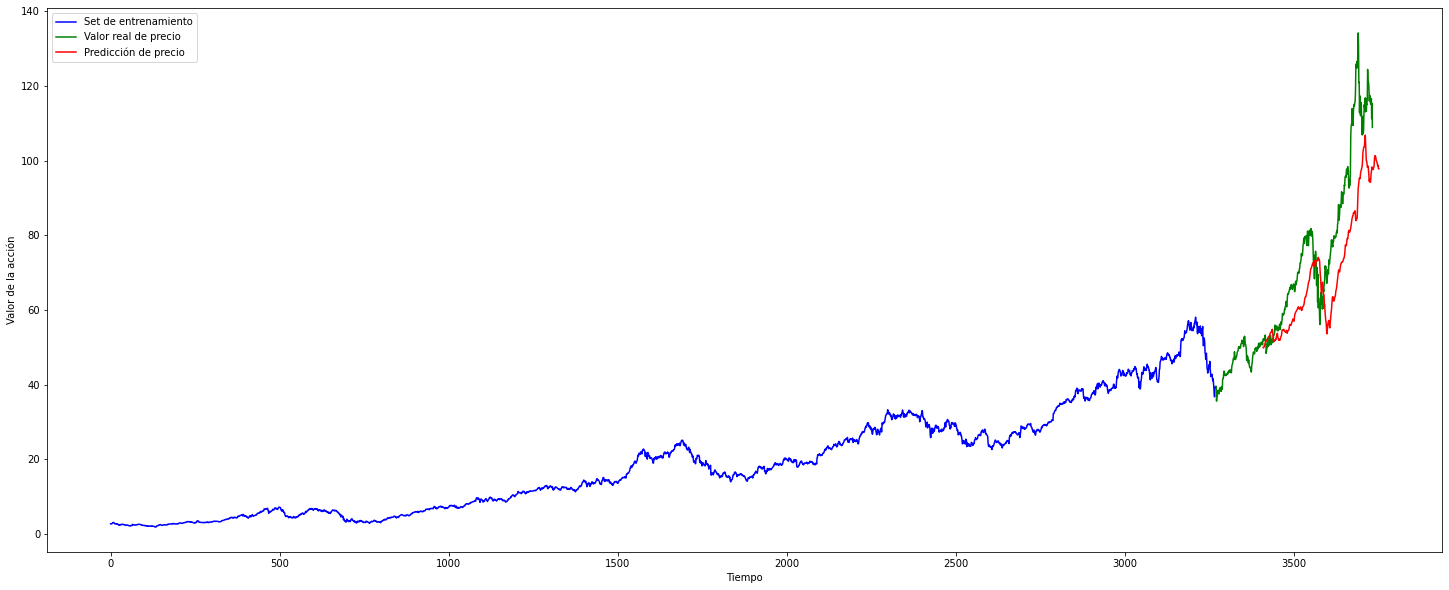

In [ ]:
# Graficar resultados
fig = plt.figure(figsize=(25,10))
fig.tight_layout()
#ax = plt.subplot(1,2, 1)
plt.plot(set_entrenamiento.values[:,3],color='blue', label='Set de entrenamiento')
#ax = plt.subplot(1,2, 2)
n1 = len(set_entrenamiento.values)
n2 = len(set_validacion.values)
n3 = len(prediccion)+time_step
plt.plot(range(n1, n1+n2, 1), set_validacion.values[:,3],color='green', label='Valor real de precio')
plt.plot(range(n1+time_step+(dias_pronostico-1), n1+n3+(dias_pronostico-1), 1), prediccion[:,3],color='red' , label='Predicción de precio')
#plt.plot(set_validacion.values[0:len(prediccion)],color='red', label='Valor real de la acción')
#plt.plot(prediccion, color='green', label='Predicción de la acción')
#plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
plt.xlabel('Tiempo')
plt.ylabel('Valor de la acción')
plt.legend()
plt.show()

## Predecir-precio-acciones-keras

https://youtu.be/Ltp-91sPBqU

In [ ]:
pip install alpha_vantage

In [ ]:
from alpha_vantage.timeseries import TimeSeries
import json


def save_dataset(symbol):
    api_key ='9XZTXGV663EISDLG'
    ts = TimeSeries(key=api_key, output_format='pandas')
    data, meta_data = ts.get_daily(symbol, outputsize='full')
    data.to_csv('./{}_daily.csv'.format(symbol))

In [ ]:
simbolo = 'AAPL'
save_dataset(simbolo)

In [ ]:
nombre_archivo = '{}_daily.csv'.format(simbolo)

In [ ]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

history_points = 50

def csv_to_dataset(csv_path):
    datos = pd.read_csv(csv_path)
    print('Datos: ', datos.head(),'\n')
    # Elimina el primer día
    datos  = datos.drop(0, axis=0)
    # Ordena de más viejo a  más reciente
    datos = datos.sort_values('date')
    print('Datos por Fecha: ', datos.head(),'\n')
    # Elimina la columna 'date'  
    datos = datos.drop('date', axis=1)
    #Normalizar datos 
    normalizador = preprocessing.MinMaxScaler()
    datos_norm = normalizador.fit_transform(datos)
    print("Datos normalizados", datos_norm[:10],'\n')
    # Usamos los últimos 50 ejemplos para predecir el siguiente valor (open)
    # X
    ohlcv_histories_normalised = np.array([datos_norm[i  : i + history_points].copy() for i in range(len(datos_norm) - history_points)])
    #y
    next_day_open_values_normalised = np.array([datos_norm[:,0][i + history_points].copy() for i in range(len(datos_norm) - history_points)])
    next_day_open_values = np.array([datos.iloc[:,0][i + history_points].copy() for i in range(len(datos) - history_points)])
    next_day_open_values = np.expand_dims(next_day_open_values_normalised, -1)
    print('next_day_open_values shape: ',next_day_open_values.shape)
    print(next_day_open_values[:10], sep = '\n')

    y_scaler = preprocessing.MinMaxScaler()
    y_scaler.fit( next_day_open_values  )

    # Indicadores tecnicos
    technical_indicators = []
    for his in ohlcv_histories_normalised:
        # Promedio del Precio de cierre 
        sma = np.mean(his[:,3])
        technical_indicators.append(np.array([sma]))

    technical_indicators = np.array(technical_indicators)
		
    tech_ind_scaler = preprocessing.MinMaxScaler()
    technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

    # Verifica que el número de xs sea igual al número de ys
    assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == technical_indicators_normalised.shape[0]

    return ohlcv_histories_normalised, technical_indicators_normalised, next_day_open_values_normalised, next_day_open_values, y_scaler

In [ ]:
ohlcv_histories, technical_indicators, next_day_open_values, unscaled_y, y_scaler = csv_to_dataset('{}_daily.csv'.format(simbolo))

test_split = 0.9
n = int(ohlcv_histories.shape[0] * test_split)

ohlcv_train = ohlcv_histories[:n]
tech_ind_train = technical_indicators[:n]
y_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
tech_ind_test = technical_indicators[n:]
y_test = next_day_open_values[n:]

unscaled_y_test = unscaled_y[n:]

Datos:           date  1. open   2. high  3. low  4. close    5. volume
0  2020-12-02   122.02  123.3700  120.89    123.08   87489822.0
1  2020-12-01   121.01  123.4693  120.01    122.72  125920963.0
2  2020-11-30   116.97  120.9700  116.81    119.05  169410176.0
3  2020-11-27   116.57  117.4900  116.22    116.59   46691331.0
4  2020-11-25   115.55  116.7500  115.17    116.03   76499234.0 

Datos por Fecha:              date  1. open  2. high  3. low  4. close  5. volume
5306  1999-11-01    80.00    80.69   77.37     77.62  2487300.0
5305  1999-11-02    78.00    81.69   77.31     80.25  3564600.0
5304  1999-11-03    81.62    83.25   81.00     81.50  2932700.0
5303  1999-11-04    82.06    85.37   80.62     83.62  3384700.0
5302  1999-11-05    84.62    88.37   84.00     88.31  3721500.0 

Tipo de de los Datos: <class 'pandas.core.frame.DataFrame'> 

Datos:        1. open  2. high  3. low  4. close  5. volume
5306    80.00    80.69   77.37     77.62  2487300.0
5305    78.00    81.69   77.

In [ ]:

### Usa tensorflow 1.x
%tensorflow_version 1.x

TensorFlow 1.x selected.


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


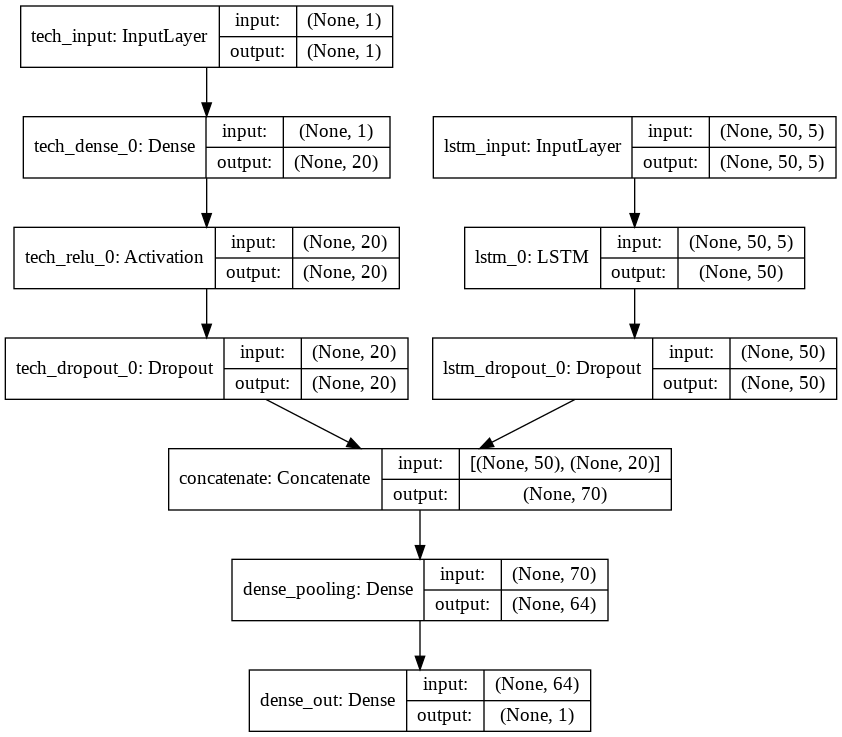

In [ ]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np



# define two sets of inputs
lstm_input = Input(shape=(history_points, 5), name='lstm_input')
dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')
 
# the first branch operates on the first input
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)
 
# the second branch opreates on the second input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)
 
# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')
 
z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
z = Dense(1, activation="linear", name='dense_out')(z)
 
# our model will accept the inputs of the two branches and then output a single value
model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam,
              loss='mse')

from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.fit(x=[ohlcv_train, tech_ind_train], y=y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)


Train on 4257 samples, validate on 473 samples
Epoch 1/50
4257/4257 [==============================] - 5s 1ms/step - loss: 0.0097 - val_loss: 1.7409e-04
Epoch 2/50
4257/4257 [==============================] - 4s 892us/step - loss: 0.0015 - val_loss: 3.5117e-04
Epoch 3/50
4257/4257 [==============================] - 4s 879us/step - loss: 0.0013 - val_loss: 6.0685e-05
Epoch 4/50
4257/4257 [==============================] - 4s 881us/step - loss: 0.0011 - val_loss: 1.9335e-04
Epoch 5/50
4257/4257 [==============================] - 4s 866us/step - loss: 9.5796e-04 - val_loss: 2.5532e-04
Epoch 6/50
4257/4257 [==============================] - 4s 872us/step - loss: 9.9051e-04 - val_loss: 2.2694e-05
Epoch 7/50
4257/4257 [==============================] - 4s 874us/step - loss: 8.8250e-04 - val_loss: 1.7492e-04
Epoch 8/50
4257/4257 [==============================] - 4s 876us/step - loss: 8.3681e-04 - val_loss: 2.4378e-05
Epoch 9/50
4257/4257 [==============================] - 4s 873us/step - lo

In [ ]:
# Las predicciones estásn normalizadas
y_test_predicted = model.predict([ohlcv_test, tech_ind_test])

y_test_predicted = y_scaler.inverse_transform(y_test_predicted)

real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(scaled_mse)

0.11873789321900814


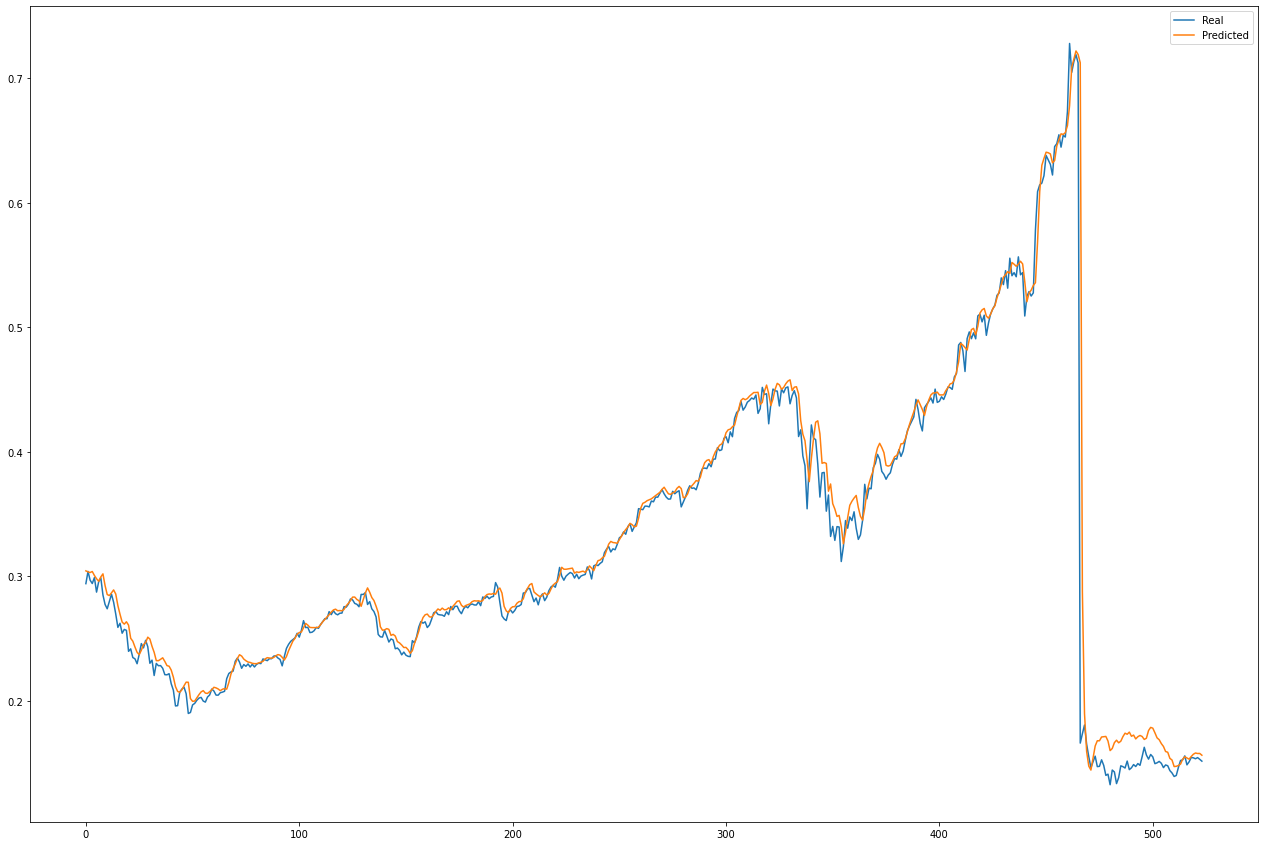

In [ ]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()


In [ ]:

buys = []
sells = []
thresh = 0.01#0.2

x = 0
for ohlcv, ind in zip(ohlcv_test, tech_ind_test):
    normalised_price_today = ohlcv[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    price_today = y_scaler.inverse_transform(normalised_price_today)
    predicted = np.squeeze(y_scaler.inverse_transform( model.predict([[ohlcv], [ind]])))
    delta = predicted - price_today
    # print(delta)
    if delta > thresh:
        buys.append((x, price_today[0][0]))
    elif delta < -thresh:
        sells.append((x, price_today[0][0]))
    x += 1
print(len(buys))
print(len(sells))

In [ ]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00')  # verde
plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000') # rojo

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])


plt.savefig('predicciones.png')

plt.show()

In [ ]:
def compute_earnings(buys, sells):
    purchase_amt = 10
    stock = 0
    balance = 0
    while len(buys) > 0 and len(sells) > 0:
        if buys[0][0] < sells[0][0]:
            # time to buy $10 worth of stock
            balance -= purchase_amt
            stock += purchase_amt / buys[0][1]
            buys.pop(0)
        else:
            # time to sell all of our stock
            balance += stock * sells[0][1]
            stock = 0
            sells.pop(0)
    print(balance)

In [ ]:
compute_earnings(buys, sells)

## Modelos ARIMA
Modelos ARIMA, su nombre se debe a que es un modelo autoregresivo y media movil es decir el modelo se constituye de un componente a partir de observaciones de periodos pasado y el promedio en una ventana del tiempo.

Para esta aplicación vamos a utilizar una base de datos del precio de la criptomoneda bitcoin.

Estos datos pueden ser descargados en el siguiente enlace.
https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import datetime

In [ ]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2018, 2, 19)
bitcoin = web.DataReader('BTC-USD', 'yahoo', start, end)
bitcoin.tail()

High           Low  ...      Volume     Adj Close
Date                                    ...                          
2018-02-16  10324.099609   9824.820312  ...  7296159744  10233.900391
2018-02-17  11139.500000  10149.400391  ...  8660880384  11112.700195
2018-02-18  11349.799805  10326.000000  ...  8744009728  10551.799805
2018-02-19  11273.799805  10513.200195  ...  7652089856  11225.299805
2018-02-20  11958.500000  11231.799805  ...  9926540288  11403.700195

[5 rows x 6 columns]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


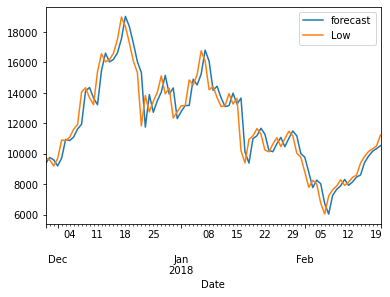

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
mod = ARIMA(bitcoin['Low'], order=(1,1,1))
res = mod.fit() 
fig = res.plot_predict(start='2017-11-28', end='2018-02-20')
fig.show()

##VAR: vector autoregression model

link: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(df.shape)  # (123, 8)
df.tail()

(123, 8)


rgnp    pgnp    ulc  gdfco    gdf  gdfim  gdfcf  gdfce
date                                                                
1988-07-01  4042.7  3971.9  179.6  131.5  124.9  106.2  123.5   92.8
1988-10-01  4069.4  3995.8  181.3  133.3  126.2  107.3  124.9   92.9
1989-01-01  4106.8  4019.9  184.1  134.8  127.7  109.5  126.6   94.0
1989-04-01  4132.5  4044.1  186.1  134.8  129.3  111.1  129.0  100.6
1989-07-01  4162.9  4068.4  187.4  137.2  130.2  109.8  129.9   98.2

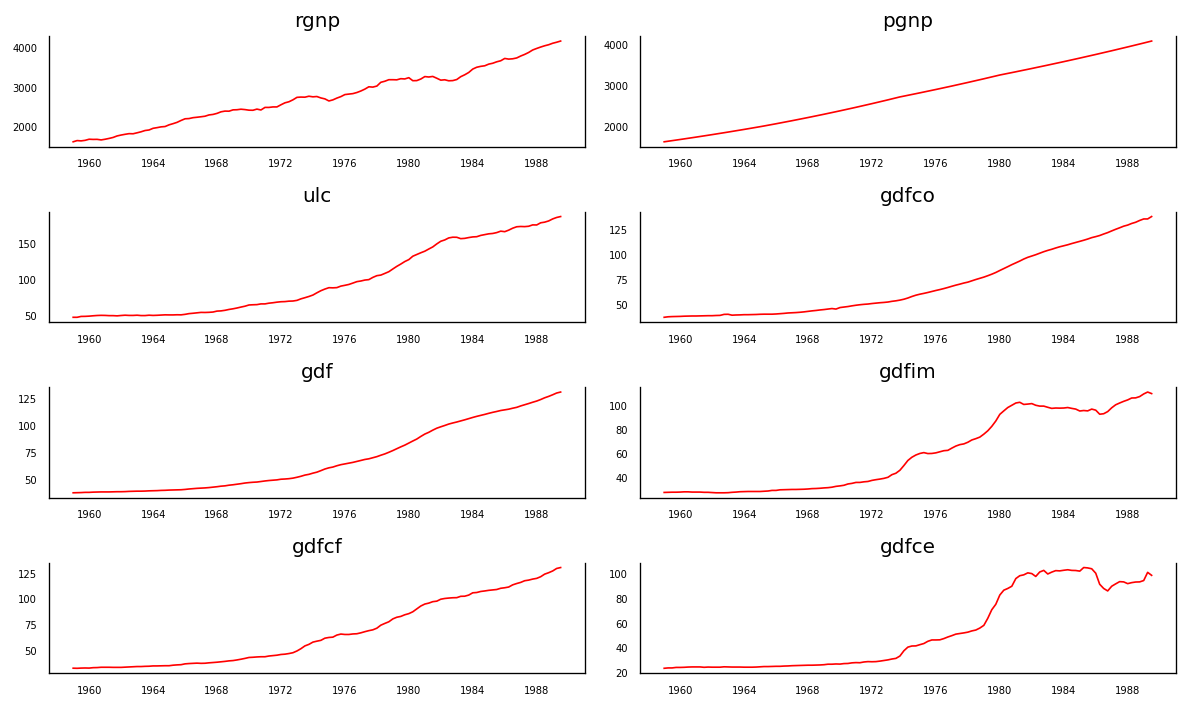

In [ ]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)    

rgnp_x  pgnp_x   ulc_x  gdfco_x   gdf_x  gdfim_x  gdfcf_x  gdfce_x
rgnp_y   1.0000  0.0003  0.0001   0.0212  0.0014   0.0620   0.0001   0.0071
pgnp_y   0.0000  1.0000  0.0000   0.0000  0.0000   0.0000   0.0000   0.0000
ulc_y    0.0000  0.0000  1.0000   0.0002  0.0000   0.0000   0.0000   0.0041
gdfco_y  0.0000  0.0000  0.0000   1.0000  0.0000   0.0000   0.0000   0.0000
gdf_y    0.0000  0.0000  0.0000   0.0000  1.0000   0.0000   0.0000   0.0000
gdfim_y  0.0011  0.0067  0.0014   0.0083  0.0011   1.0000   0.0004   0.0000
gdfcf_y  0.0000  0.0000  0.0008   0.0008  0.0000   0.0038   1.0000   0.0009
gdfce_y  0.0025  0.0485  0.0000   0.0002  0.0000   0.0000   0.0000   1.0000

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
rgnp   ::  248.0     > 143.6691  =>   True
pgnp   ::  183.12    > 111.7797  =>   True
ulc    ::  130.01    > 83.9383   =>   True
gdfco  ::  85.28     > 60.0627   =>   True
gdf    ::  55.05     > 40.1749   =>   True
gdfim  ::  31.59     > 24.2761   =>   True
gdfcf  ::  14.06     > 12.3212   =>   True
gdfce  ::  0.45      > 4.1296    =>   False


In [ ]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(119, 8)
(4, 8)


In [ ]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [ ]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.5428
 No. Lags Chosen       = 2
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.9861. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.1556
 No. Lags Chosen       = 1
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.9957. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. N

In [ ]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [ ]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3448
 No. Lags Chosen       = 1
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.8282
 No. Lags Chosen       = 0
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.3666. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

In [ ]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [ ]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "rgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.0123
 No. Lags Chosen       = 2
 Critical value 1%     = -3.489
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pgnp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.9813
 No. Lags Chosen       = 0
 Critical value 1%     = -3.488
 Critical value 5%     = -2.887
 Critical value 10%    = -2.58
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ulc" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 T

In [ ]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -1.3679402315450677
BIC :  0.34118471465888245
FPE :  0.2552682517347194
HQIC:  -0.6741331335699567 

Lag Order = 2
AIC :  -1.621237394447824
BIC :  1.6249432095295848
FPE :  0.2011349437137139
HQIC:  -0.3036288826795923 

Lag Order = 3
AIC :  -1.7658008387012791
BIC :  3.0345473163767833
FPE :  0.18125103746164364
HQIC:  0.18239143783963296 

Lag Order = 4
AIC :  -2.0007351644703144
BIC :  4.371215137654091
FPE :  0.15556966521481155
HQIC:  0.5849359332771105 

Lag Order = 5
AIC :  -1.9619535608363963
BIC :  5.999364562242095
FPE :  0.1869279438911487
HQIC:  1.268206331178332 

Lag Order = 6
AIC :  -2.3303386524829035
BIC :  7.238452689088582
FPE :  0.16380374017443694
HQIC:  1.551437166954809 

Lag Order = 7
AIC :  -2.592331352347122
BIC :  8.602387254937803
FPE :  0.18238685837154273
HQIC:  1.9483069621146623 

Lag Order = 8
AIC :  -3.3172619764582016
BIC :  9.522195810323034
FPE :  0.15573163248209143
HQIC:  1.889607138622102 

Lag Order = 9
AIC :  -4.804763125

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [ ]:
x = model.select_order(maxlags=12)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 27, Nov, 2020
Time:                     18:31:00
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.37122
Nobs:                     113.000    HQIC:                  0.584936
Log likelihood:          -905.679    FPE:                   0.155570
AIC:                     -2.00074    Det(Omega_mle):       0.0200322
--------------------------------------------------------------------
Results for equation rgnp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.430021         2.677505            0.908           0.364
L1.rgnp         -0.750066         0.159023           -4.717           0.000
L1.pgnp         -0.095621         4.938865           -0.019           0.985
L1.ul

In [ ]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

NameError: ignored

In [ ]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[ 13.5,   0.1,   1.4,   0.1,   0.1,  -0.1,   0.4,  -2. ],
       [-23.6,   0.2,  -2. ,  -0.5,  -0.1,  -0.2,  -0.3,  -1.2],
       [ -3.3,   0.1,   3.1,   0.5,   0.3,   0.4,   0.9,   2.2],
       [ -3.9,   0.2,  -2.1,  -0.4,   0.2,  -1.5,   0.9,  -0.3]])

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

rgnp_2d   pgnp_2d    ulc_2d  ...  gdfim_2d  gdfcf_2d  gdfce_2d
date                                       ...                              
1988-10-01  48.322456  1.250774  0.595993  ...  0.304119 -0.917227 -0.113061
1989-01-01 -34.962286 -0.387966 -0.329877  ...  1.357223  0.618163  3.029975
1989-04-01  20.392680  0.291298  0.390812  ... -0.149551 -1.238234 -2.345223
1989-07-01 -37.416599 -0.280943  0.367912  ... -0.502103  0.469468  0.517424

[4 rows x 8 columns]

In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [ ]:
df_results = invert_transformation(train, df_forecast, second_diff=True)        
df_results.loc[:, ['rgnp_forecast', 'pgnp_forecast', 'ulc_forecast', 'gdfco_forecast',
                   'gdf_forecast', 'gdfim_forecast', 'gdfcf_forecast', 'gdfce_forecast']]

NameError: ignored

NameError: ignored

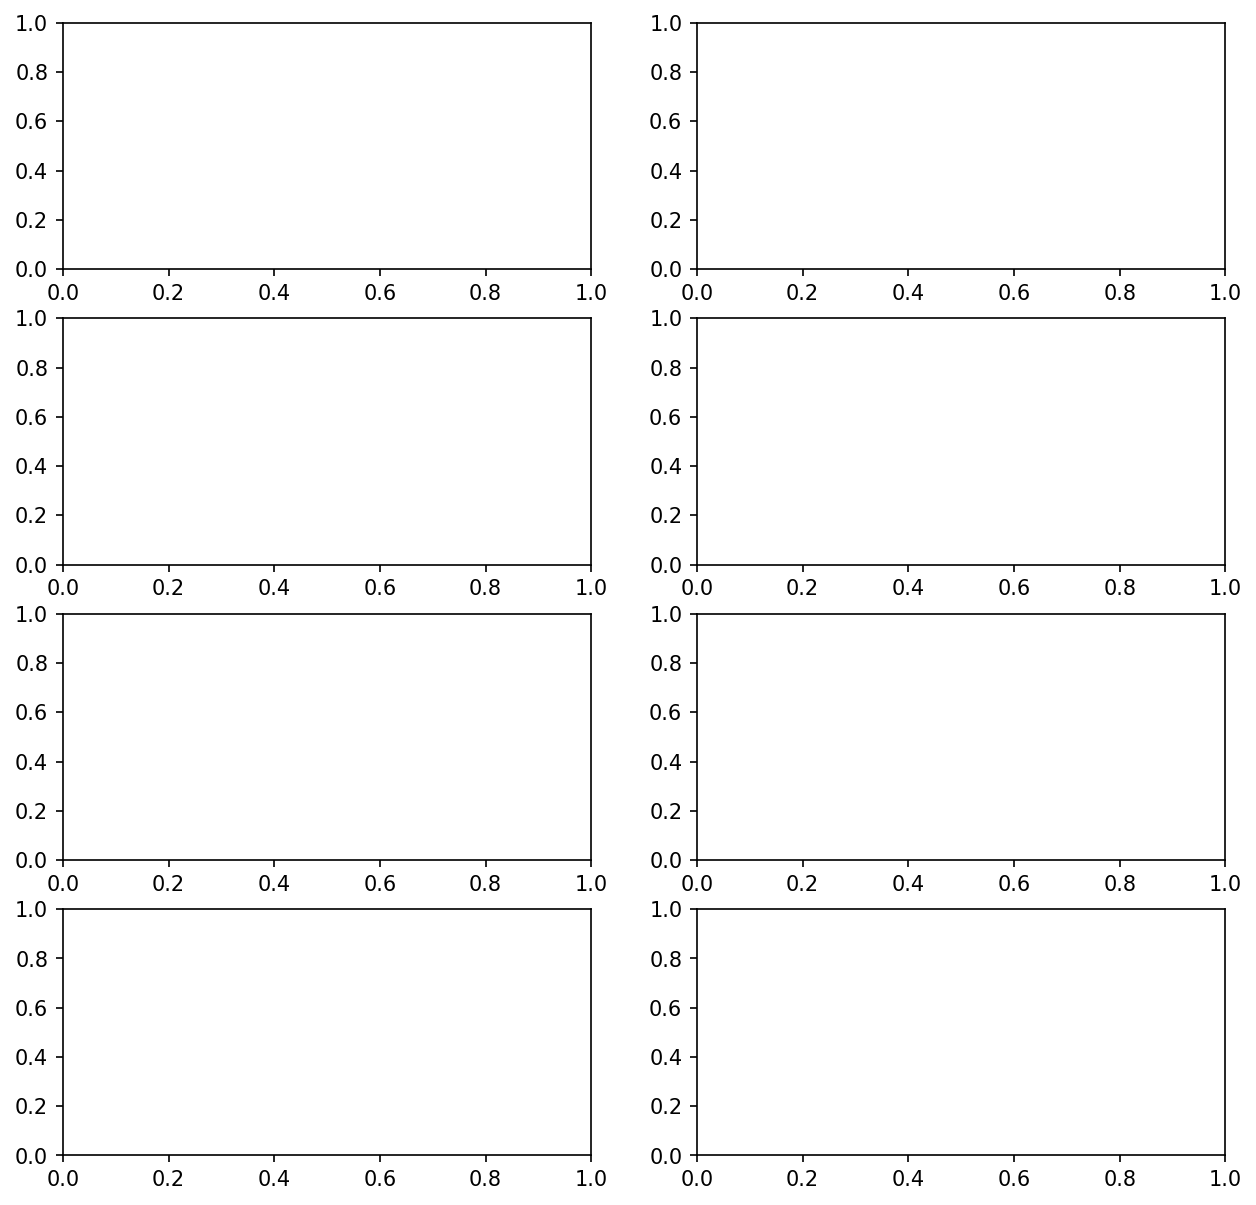

In [ ]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['rgnp_forecast'].values, df_test['rgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: pgnp')
accuracy_prod = forecast_accuracy(df_results['pgnp_forecast'].values, df_test['pgnp'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: ulc')
accuracy_prod = forecast_accuracy(df_results['ulc_forecast'].values, df_test['ulc'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfco')
accuracy_prod = forecast_accuracy(df_results['gdfco_forecast'].values, df_test['gdfco'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdf')
accuracy_prod = forecast_accuracy(df_results['gdf_forecast'].values, df_test['gdf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfim')
accuracy_prod = forecast_accuracy(df_results['gdfim_forecast'].values, df_test['gdfim'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfcf')
accuracy_prod = forecast_accuracy(df_results['gdfcf_forecast'].values, df_test['gdfcf'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: gdfce')
accuracy_prod = forecast_accuracy(df_results['gdfce_forecast'].values, df_test['gdfce'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp


NameError: ignored

##Vector Autoregressions tsa.vector_ar

https://www.statsmodels.org/dev/vector_ar.html

In [ ]:
import numpy as np
import pandas 
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in log



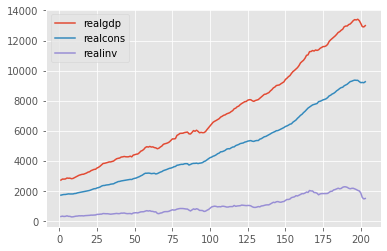

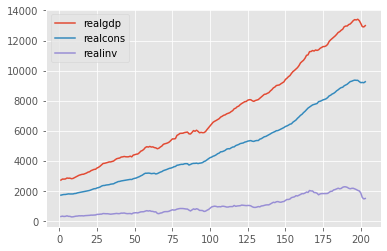

In [ ]:
mdata = sm.datasets.macrodata.load_pandas().data
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
#print(mdata)

zeros = pandas.DataFrame(data= {'realgdp': [0], 'realcons': [0],'realinv':[0]})
df = pandas.concat([zeros, mdata[['realgdp','realcons','realinv']]], ignore_index=True)

np.exp(np.log(df.diff().cumsum())).plot()
#np.exp(
np.exp(np.log(df)).diff().cumsum().plot()

In [ ]:
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)
mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)
data = np.log(mdata.pct_change()+1).dropna()

# make a VAR model
model = VAR(data)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.



In [ ]:
results = model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 01, Dec, 2020
Time:                     05:35:29
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

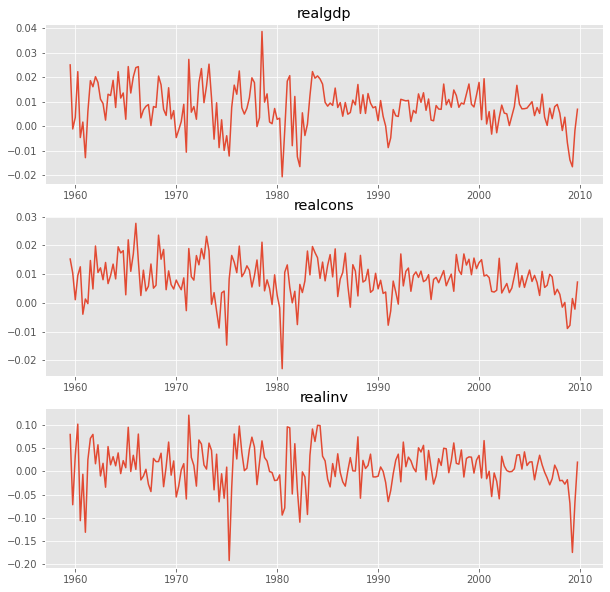

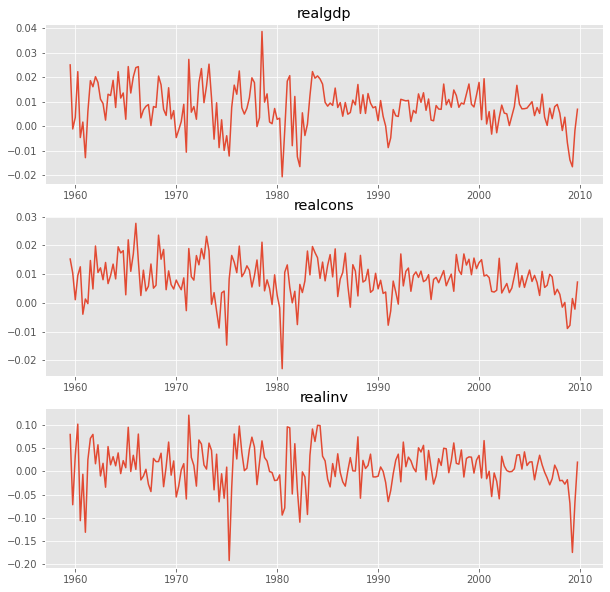

In [ ]:
results.plot()

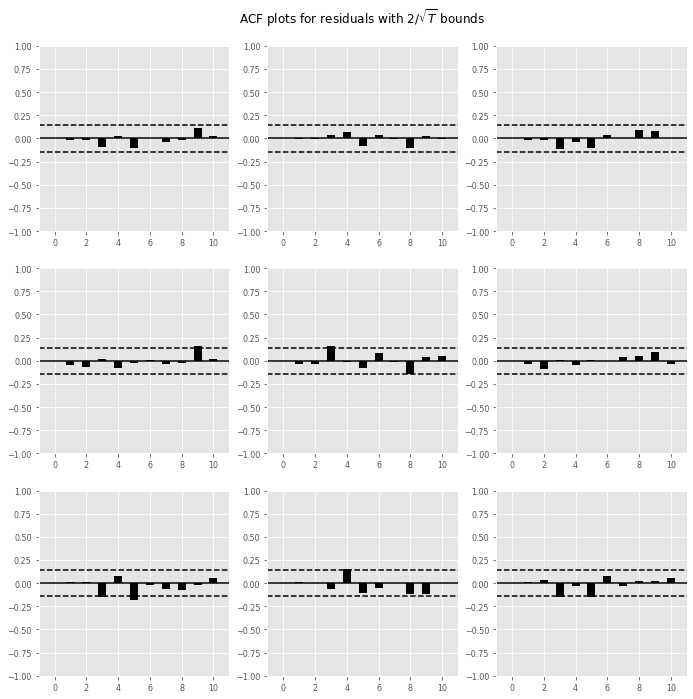

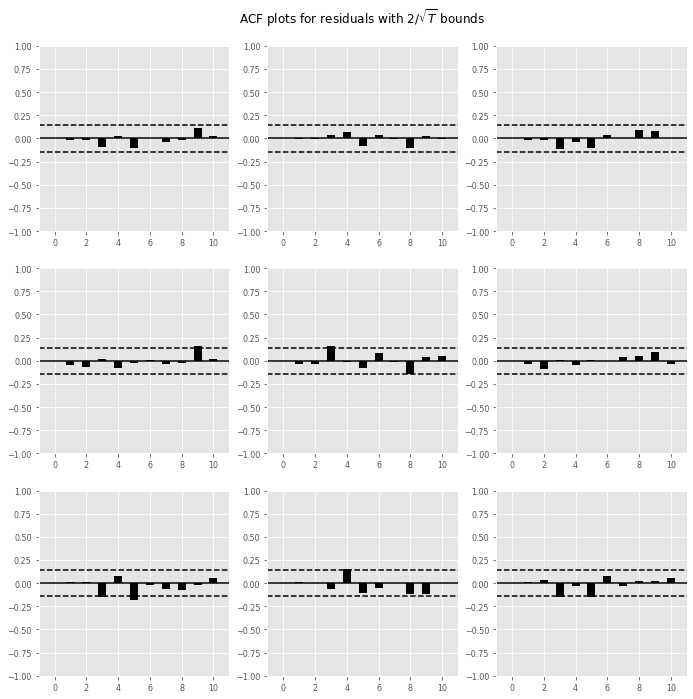

In [ ]:
results.plot_acorr()

In [ ]:
model.select_order(15)
results = model.fit(maxlags=30, ic='aic')

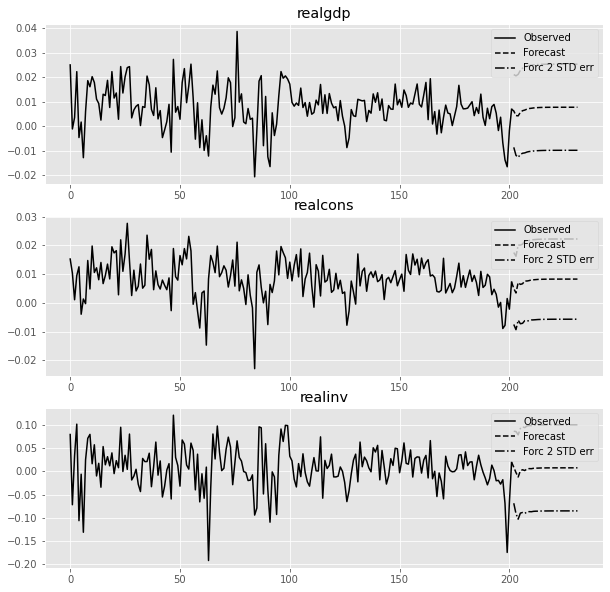

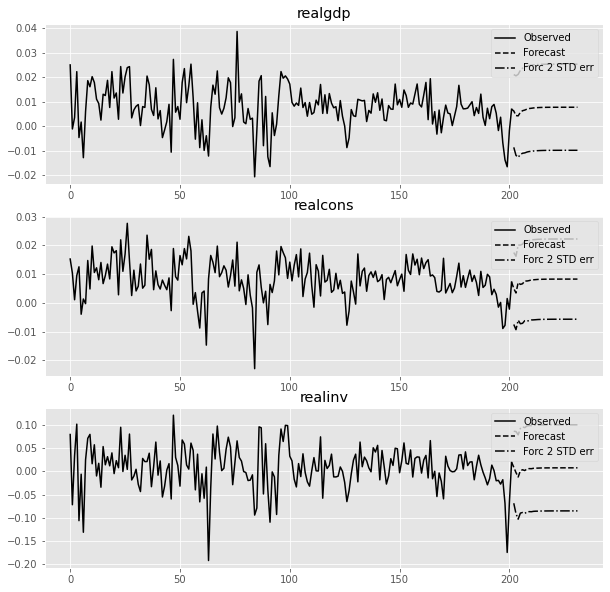

In [ ]:
lag_order = results.k_ar
results.forecast(data.values[-lag_order:], 5)
results.plot_forecast(30)

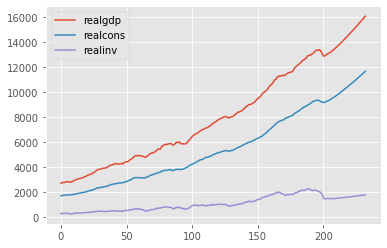

In [ ]:
forecast_periods = 30

return_forecast = pandas.DataFrame(results.forecast(data.values[-lag_order:], forecast_periods),columns=['realgdp','realcons','realinv'])
return_complete = pandas.concat([data,return_forecast], ignore_index=True)
return_complete = np.exp(return_complete)
price_complete = pandas.concat([pandas.DataFrame(mdata.iloc[0]).T,return_complete], ignore_index=True).cumprod()
price_complete.plot()


##VAR pt3

https://youtu.be/6Ye0CsfRDJg

In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

In [ ]:
def parser(s):
    return datetime.strptime(s, '%Y-%m')

data

In [ ]:
ice_cream_heater_df = pd.read_csv('ice_cream_vs_heater.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

ice_cream_heater_df = ice_cream_heater_df.asfreq(pd.infer_freq(ice_cream_heater_df.index))

In [ ]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

normalize

In [ ]:

avgs = ice_cream_heater_df.mean()
devs = ice_cream_heater_df.std()

In [ ]:
for col in ice_cream_heater_df.columns:
    ice_cream_heater_df[col] = (ice_cream_heater_df[col] - avgs.loc[col]) / devs.loc[col]

In [ ]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

Take First Difference to Remove Trend

In [ ]:

ice_cream_heater_df = ice_cream_heater_df.diff().dropna()

In [ ]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

In [ ]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=16)

Remove Increasing Volatility

In [ ]:
annual_volatility = ice_cream_heater_df.groupby(ice_cream_heater_df.index.year).std()
annual_volatility

In [ ]:
ice_cream_heater_df['ice_cream_annual_vol'] = ice_cream_heater_df.index.map(lambda d: annual_volatility.loc[d.year, 'ice cream'])
ice_cream_heater_df['heater_annual_vol'] = ice_cream_heater_df.index.map(lambda d: annual_volatility.loc[d.year, 'heater'])
ice_cream_heater_df

In [ ]:

ice_cream_heater_df['ice cream'] = ice_cream_heater_df['ice cream'] / ice_cream_heater_df['ice_cream_annual_vol']
ice_cream_heater_df['heater'] = ice_cream_heater_df['heater'] / ice_cream_heater_df['heater_annual_vol']

In [ ]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=16)

In [ ]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)


Remove Seasonality

In [ ]:
month_avgs = ice_cream_heater_df.groupby(ice_cream_heater_df.index.month).mean()
month_avgs

In [ ]:
ice_cream_heater_df['ice_cream_month_avg'] = ice_cream_heater_df.index.map(lambda d: month_avgs.loc[d.month, 'ice cream'])
ice_cream_heater_df['heater_month_avg'] = ice_cream_heater_df.index.map(lambda d: month_avgs.loc[d.month, 'heater'])
ice_cream_heater_df

In [ ]:
ice_cream_heater_df['ice cream'] = ice_cream_heater_df['ice cream'] - ice_cream_heater_df['ice_cream_month_avg']
ice_cream_heater_df['heater'] = ice_cream_heater_df['heater'] - ice_cream_heater_df['heater_month_avg']
ice_cream_heater_df

In [ ]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream'], fontsize=16)

In [ ]:
plt.figure(figsize=(12,6))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'])
heater, = plt.plot(ice_cream_heater_df['heater'], color='red')

for year in range(2004, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.ylabel('First Difference', fontsize=18)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

PACF - Heater

In [ ]:
plot_pacf(ice_cream_heater_df['heater'])
plt.show()

Correlation between "heater" and lagged "ice cream"

In [ ]:
for lag in range(1, 14):
    heater_series = ice_cream_heater_df['heater'].iloc[lag:]
    lagged_ice_cream_series = ice_cream_heater_df['ice cream'].iloc[:-lag]
    print('Lag: %s'%lag)
    print(pearsonr(heater_series, lagged_ice_cream_series))
    print('------')

Fit a VAR Model

In [ ]:
ice_cream_heater_df = ice_cream_heater_df[['ice cream', 'heater']]
model = VAR(ice_cream_heater_df)
model_fit = model.fit(maxlags=13)
model_fit.summary()

So our final model is:
$$
\hat{h}_t = - 0.41h_{t-1} - 0.19h_{t-2} + 0.2i_{t-13}
$$

# Implementación de Modelos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

###1.Load Data:


download data from: https://drive.google.com/drive/folders/1xjPE-SPFbUTmVM2EGy0R8iSG-eJEMCLN?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Colombia
Starting Date:  2003-01-24 00:00:00
(4620, 1)


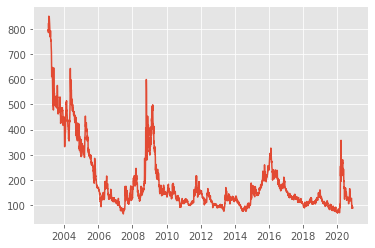

Mexico
Starting Date:  2001-10-12 00:00:00
(4889, 1)


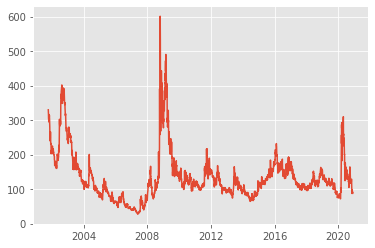

Chile
Starting Date:  2003-01-24 00:00:00
(4591, 12)


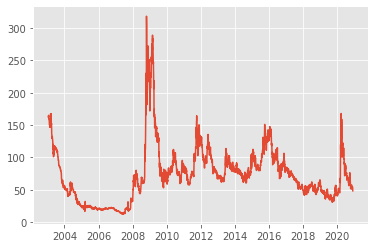

Brasil
Starting Date:  2001-10-12 00:00:00
(4882, 1)


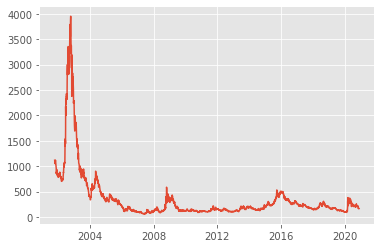

Rusia
Starting Date:  2000-11-27 00:00:00
(5031, 12)


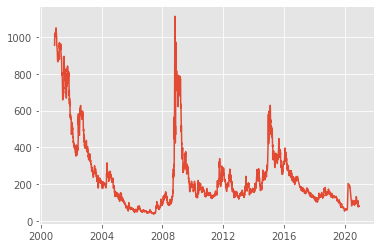

Japon
Starting Date:  2003-01-06 00:00:00
(3451, 12)


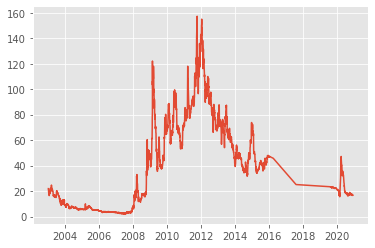

China
Starting Date:  2003-01-24 00:00:00
(4346, 12)


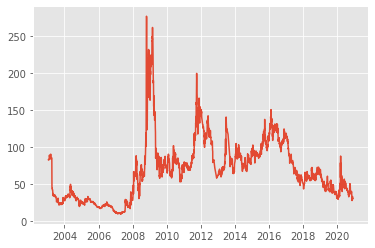

Francia
Starting Date:  2003-03-31 00:00:00
(4070, 12)


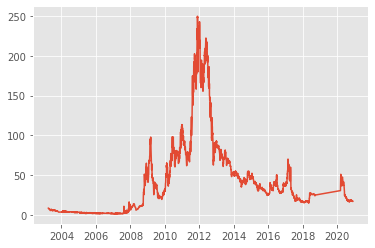

Alemania
Starting Date:  2003-03-03 00:00:00
(4003, 12)


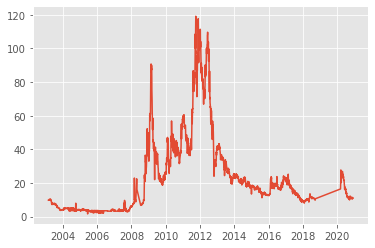

In [ ]:
CDS_list = ['Colombia','Mexico', 'Chile', 'Brasil', 'Rusia','Japon','China','Francia','Alemania'] #,'Argentina'
CDS_dictionary = {}

#Getting every country's CDS price history 
#into a Dataframe inside of a dictionary:
for country in CDS_list:
  try:
    CDS_dictionary[country] = pd.read_excel('/content/drive/MyDrive/Principal/universidad/data science/proyecto final/data/CDS_{}.xlsx'.format(country) ,header=6, index_col='Date')
  except:
    CDS_dictionary[country] = pd.read_excel('/content/drive/MyDrive/Principal/universidad/data science/proyecto final/data/CDS_{}_ohlc.xlsx'.format(country) ,header=6, index_col='Date')
  CDS_dictionary[country].sort_index(inplace=True)


#changing price column name into each countrie's name
for cds in CDS_dictionary:
  CDS_dictionary[cds] = CDS_dictionary[cds].rename(columns={'PX_LAST': cds})
  #CDS_dictionary[cds] = CDS_dictionary[cds][[cds]]

#Showing/printing info from CDSs
for cds in CDS_dictionary:
  print(cds)
  print('Starting Date: ', CDS_dictionary[cds].index.min())
  print(CDS_dictionary[cds].shape)
  plt.plot(CDS_dictionary[cds][cds])
  plt.show()

###2.Prepare Data

Colombia


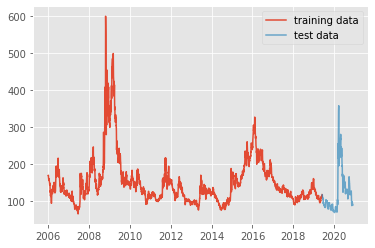

Mexico


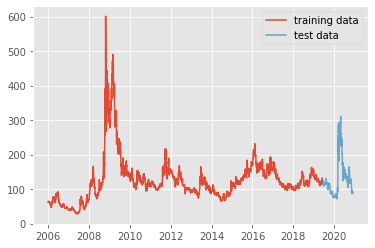

Chile


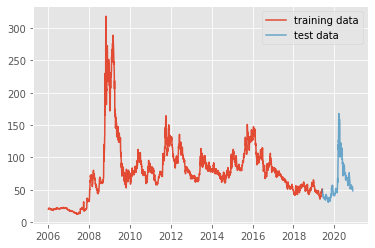

Brasil


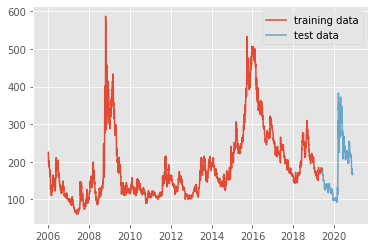

Rusia


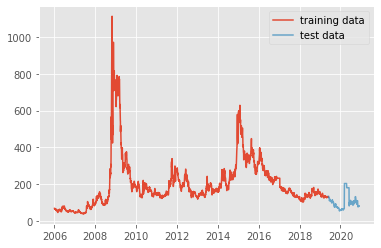

Japon


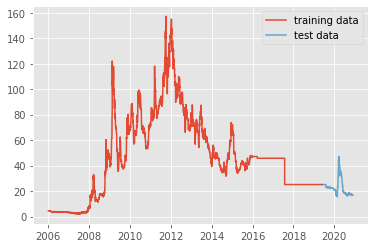

China


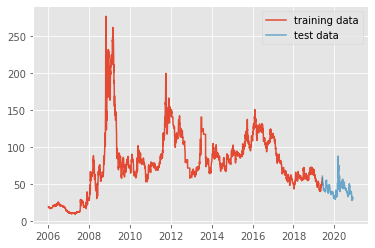

Francia


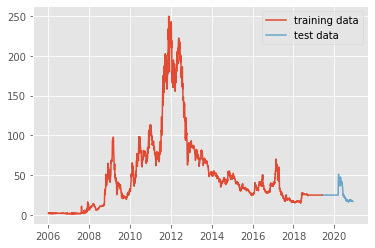

Alemania


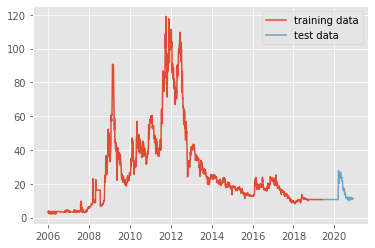

In [ ]:

#creating 1 dataframe to contain all historical prices
data = pd.DataFrame()
for cds in CDS_dictionary:
  data = data.join(CDS_dictionary[cds][cds],how='outer').fillna(method='ffill')
data = data.dropna()

#split data into train, and test
start_date = '2006'              #most of them start at 2003, so that's the minimum recomended
split_date = '2019-06'           #it could be only a year, 'year-month' or 'year-month-day'
train_data = data.loc[start_date : split_date[0:-1] + str(int(split_date[-1])-1)]
test_data = data.loc[split_date:]

#plotting price data
for cds in data.columns:
  print(cds)
  plt.plot(train_data[cds],label='training data')
  plt.plot(test_data[cds],alpha=0.7,label='test data')
  plt.legend()
  plt.show()

##Simulación Estocástica Euler-Maruyama

In [ ]:
def sim_bands(train, test, n_traj=1000, confidence=0.90):
  close_d1 = train.dropna().to_numpy()  
  n1 = len(close_d1)                                 # Number of days of year 1
  close_d2 = test.to_numpy()  
  n2 = len(close_d2)   
  # Instant Returns
  dt_i = 1/n1                  # Delta_t
  R_i = []                     # Instant returns
  for i in range(1, n1):
      R_i.append(np.log(close_d1[i] / close_d1[i - 1]))
  #Parameters:
  mu = np.mean(R_i)/dt_i         # Drift
  s = np.sqrt(np.var(R_i)/dt_i)  # Variance
  #print(mu, s)
  xs_n = []
  for traj in range(1, n_traj+1):
      xs = [close_d1[-1]]
      for i in range(1, n2):
          e = np.random.normal()
          dB_i = np.sqrt(dt_i)*e
          xs.append(xs[i-1] + mu*xs[i-1]*dt_i + s*xs[i-1]*dB_i)
      xs_n.append(xs)
  #Bands:
  U = []  # Upper band
  L = []  # Lower band
  M = []  # Median
  for t in range(n2):
      data_t = np.array([x[t] for x in xs_n])
      U.append(np.quantile(data_t, 1-(1 - confidence)/2))
      L.append(np.quantile(data_t, (1 - confidence)/2))
      M.append(np.quantile(data_t, 0.5))
  #Plots:
  plt.figure(figsize=(13, 7))
  plt.plot(close_d1) 
  for traj in range(n_traj-1):
      plt.gray()
      plt.plot(range(n1, n1+n2, 1), xs_n[traj], '0.5', alpha=.1)
  plt.plot(range(n1, n1+n2, 1), close_d2, 'c', label="Real price")
  plt.plot(range(n1, n1+n2, 1), U, 'r')
  plt.plot(range(n1, n1+n2, 1), L, 'r')
  plt.plot(range(n1, n1+n2, 1), M, 'orange')
  plt.xlim([0, n1+n2])
  plt.xlabel("Days")
  plt.ylabel("Price")
  plt.legend()
  plt.show()

Colombia


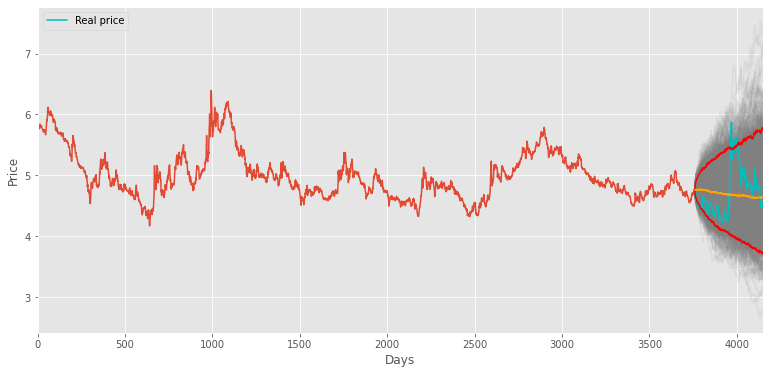

Mexico


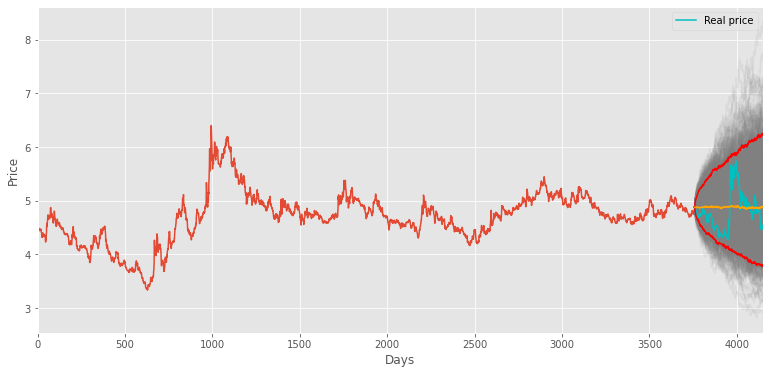

Chile


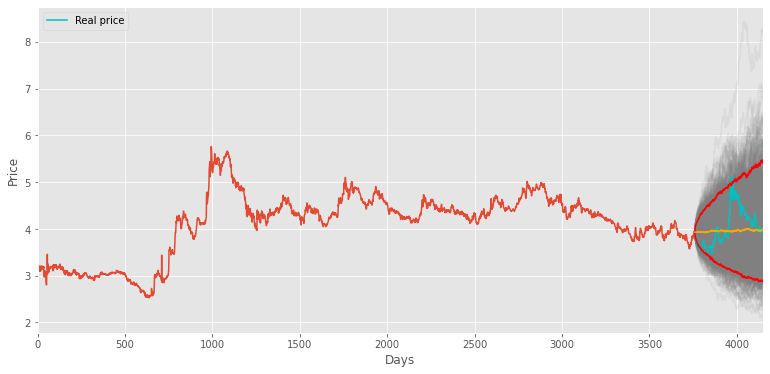

Brasil


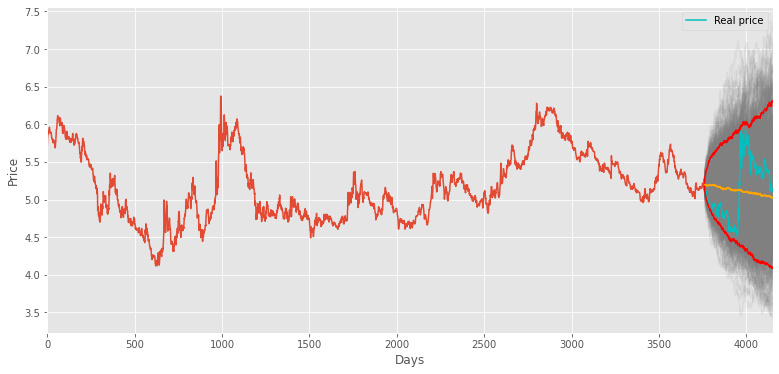

Rusia


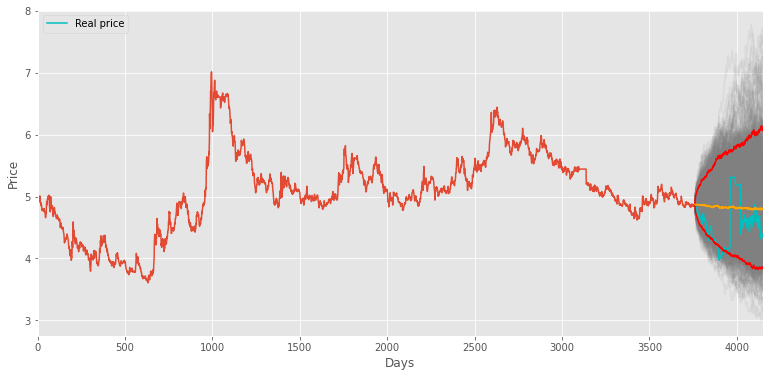

Japon


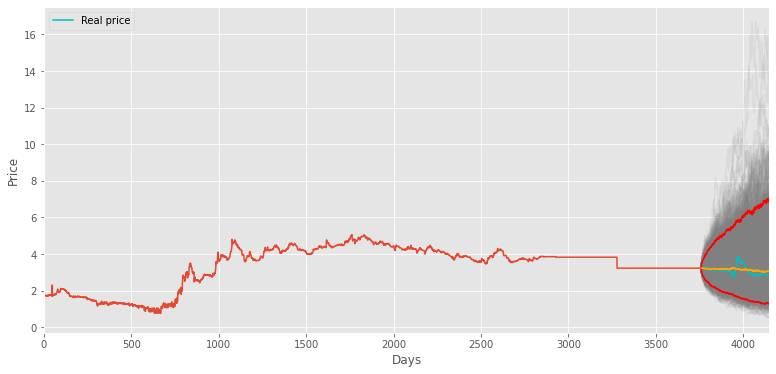

China


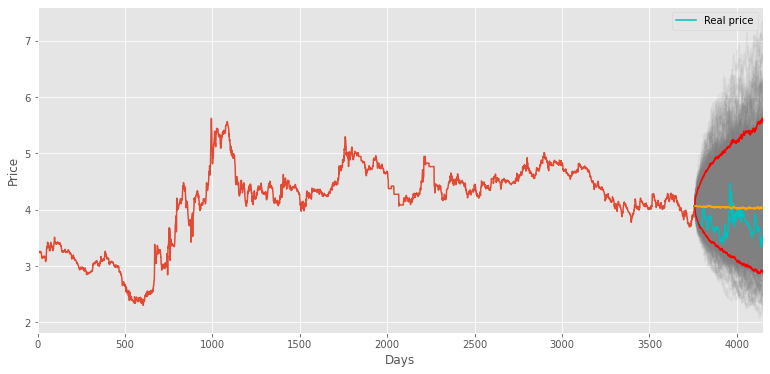

Francia


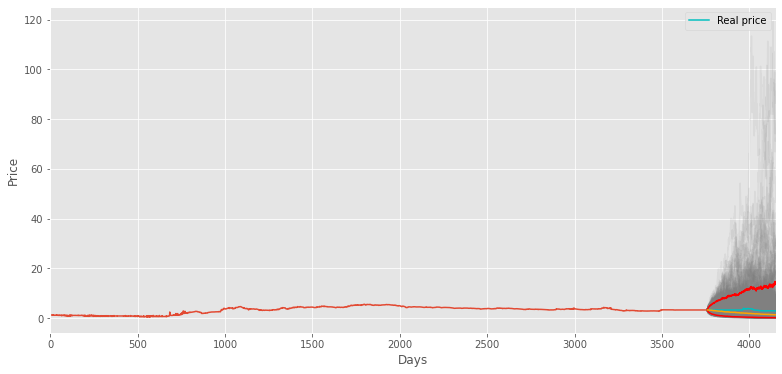

Alemania


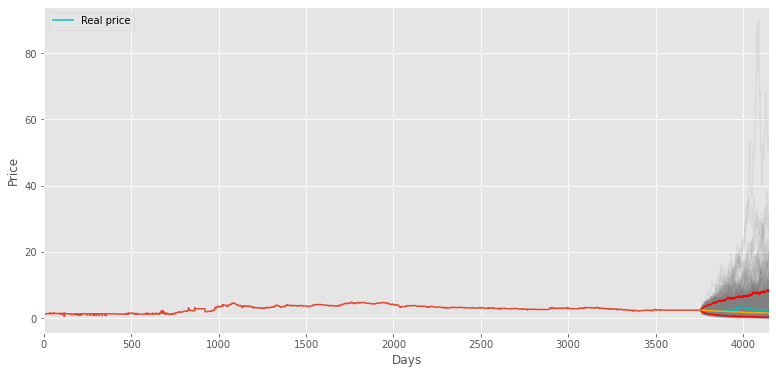

In [ ]:
for cds in data.columns:
  print(cds)
  sim_bands(np.log(train_data[cds]), np.log(test_data[cds]))

## FB Profet

In [ ]:
from fbprophet import Prophet
import datetime
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def prophet(train, test):
  #prepare data for the model
  prices = pd.DataFrame()
  prices['y'] = train.dropna().values
  prices['ds'] = train.dropna().index
  #prices = prices[['ds', 'y']].reset_index()
  test['y'] = test
  #create a prophet model
  m = Prophet(daily_seasonality=True)
  m.fit(prices)
  #create a dataframe for the future
  periods = (pd.DataFrame(test.iloc[-1]).T.index - pd.DataFrame(test.iloc[0]).T.index).days[0]
  future = m.make_future_dataframe(periods=periods, freq='D')
  #create forecast
  forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  #create plots
  fig1 = m.plot(forecast, figsize=(13,7))
  plt.plot(test,color='red')
  fig2 = m.plot_components(forecast)
  plt.show()
  return forecast

In [ ]:

for cds in data.columns:
  print(cds)
  prophet(np.log(train_data[cds]), np.log(test_data[cds]))

Colombia


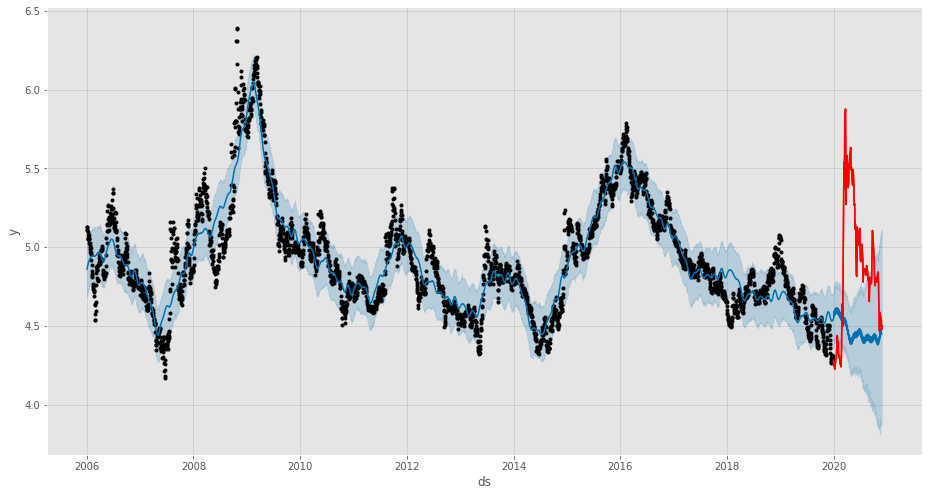

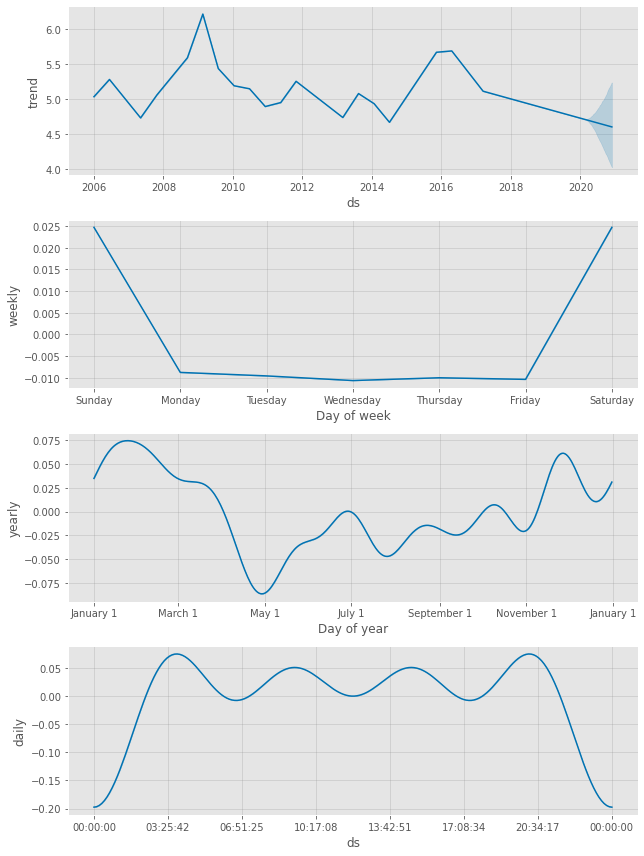

Mexico


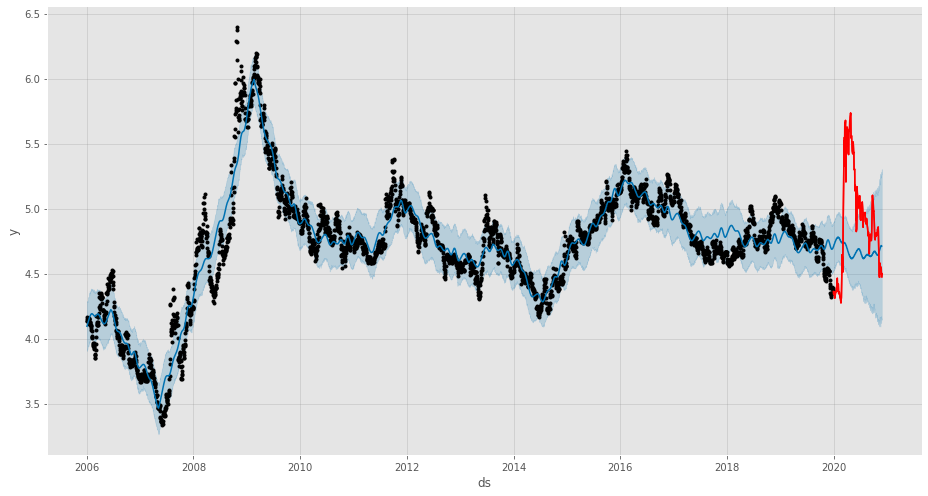

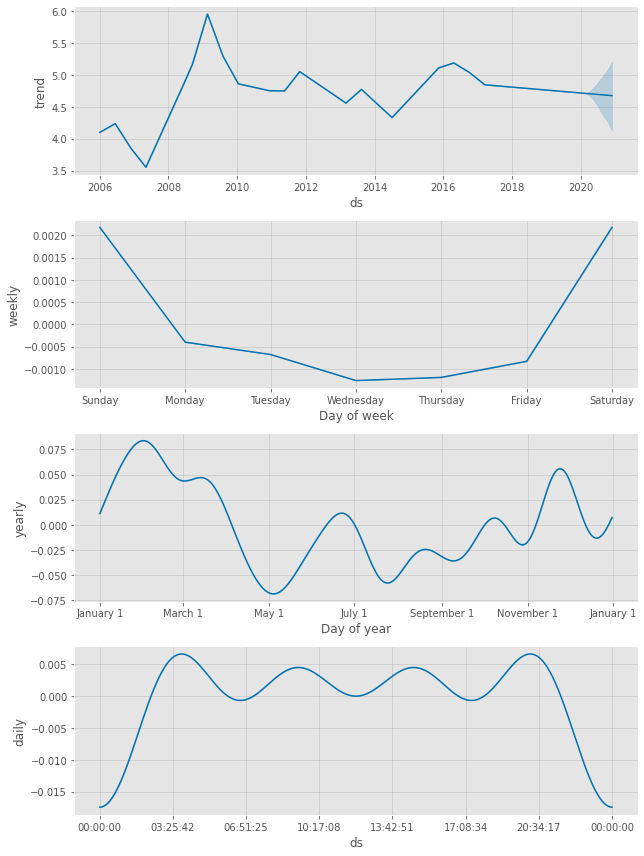

Chile


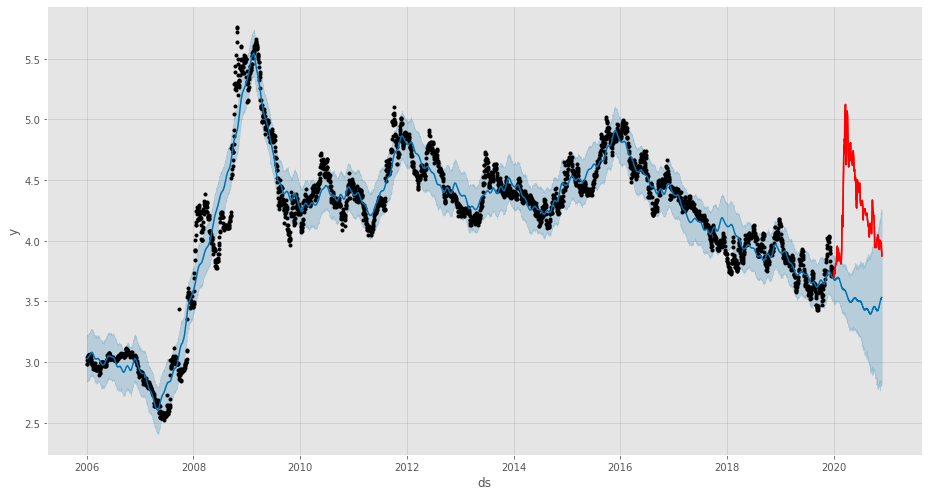

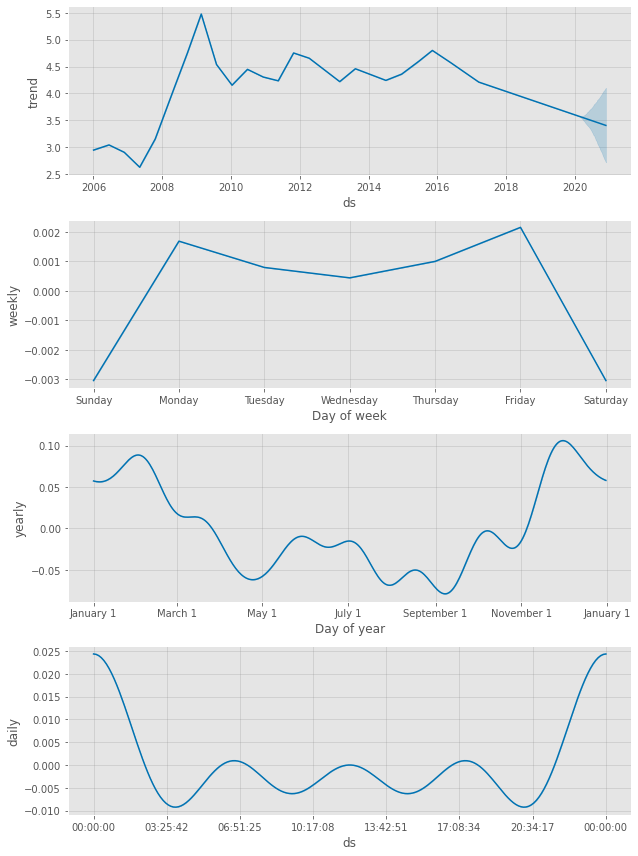

Brasil


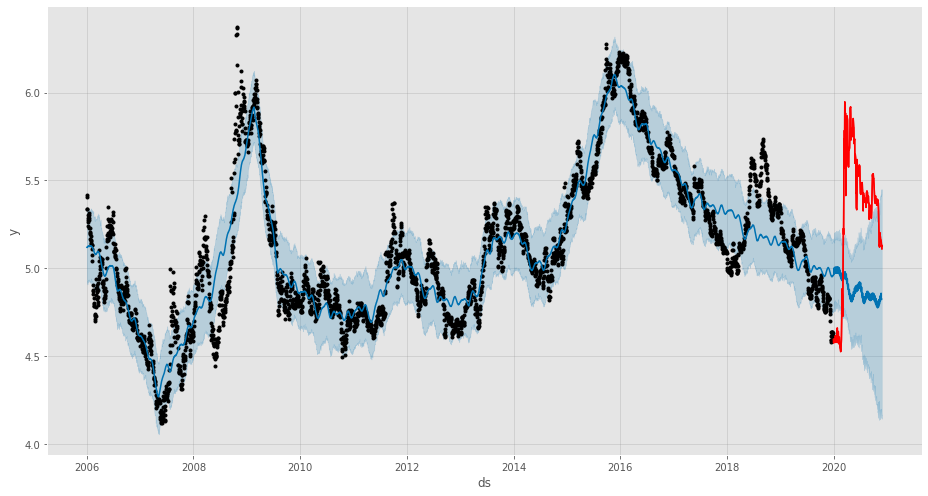

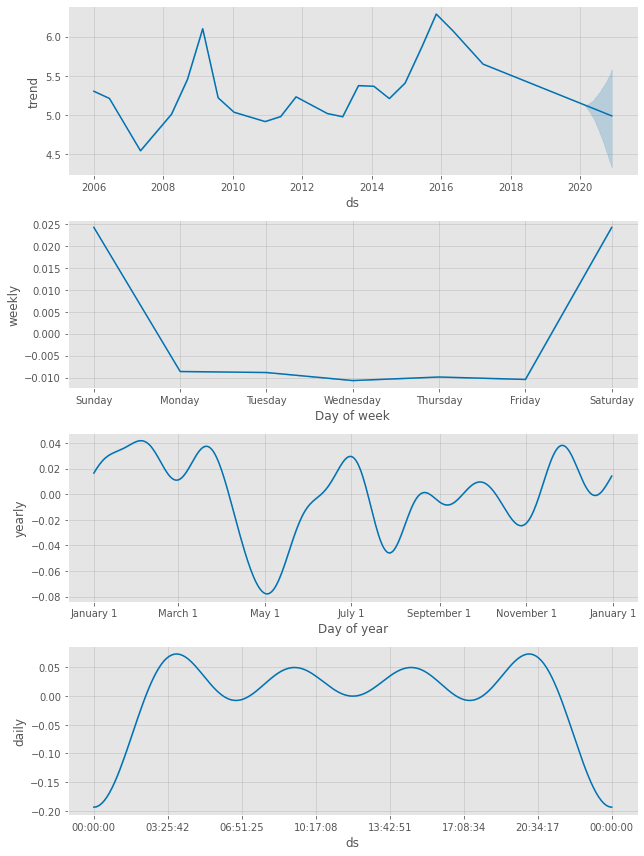

Rusia


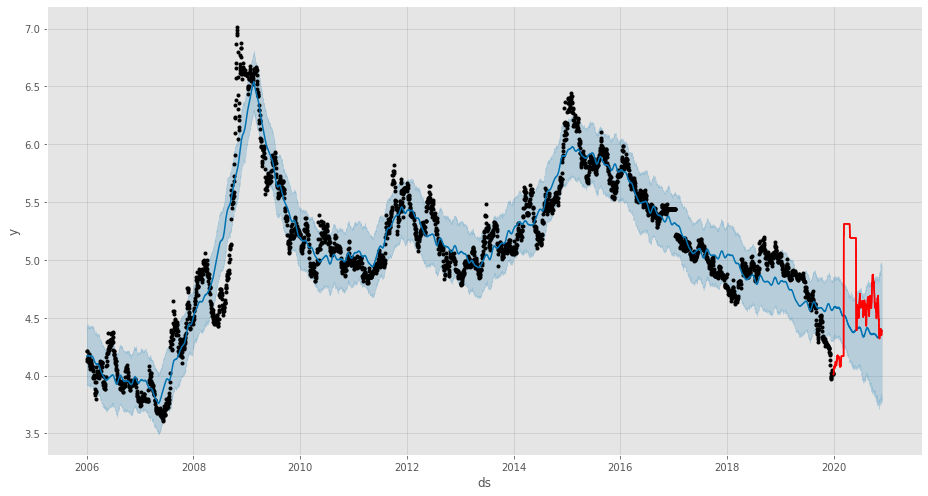

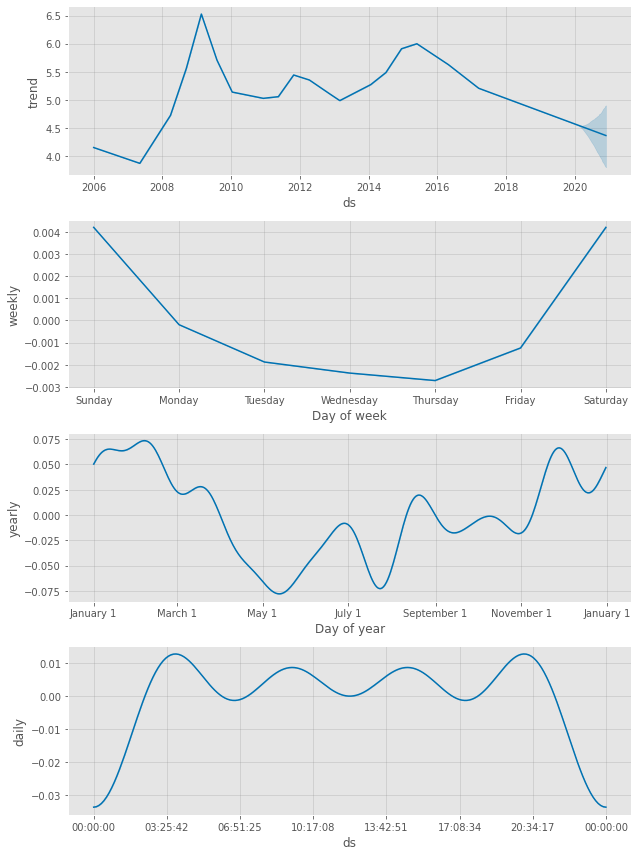

Japon


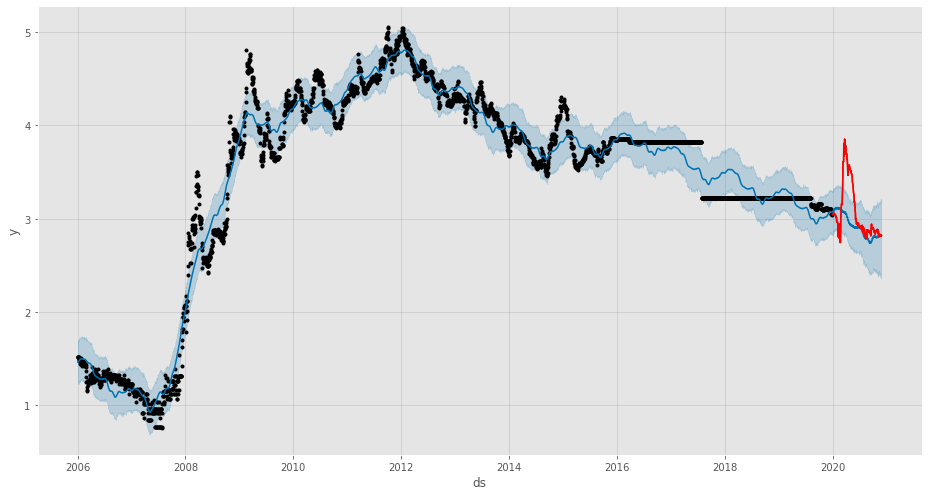

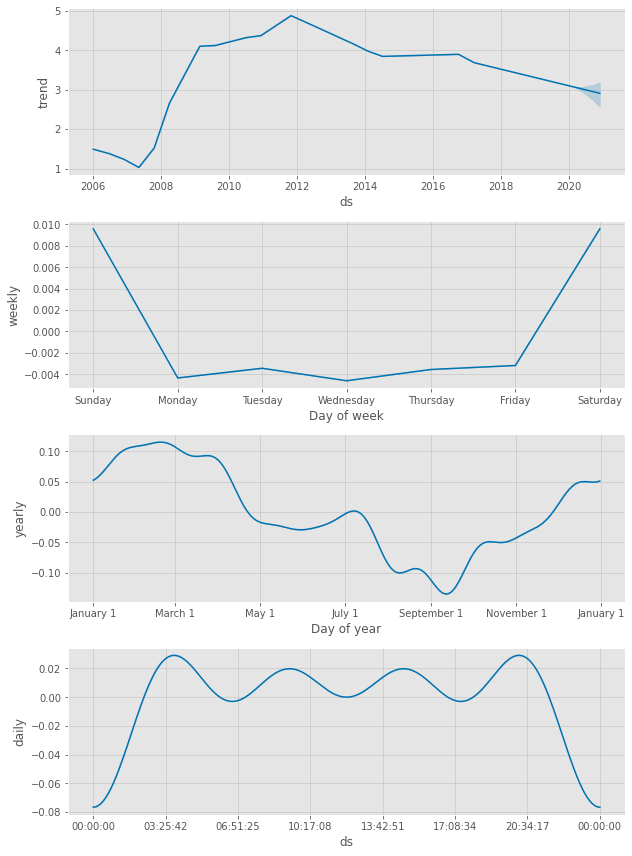

China


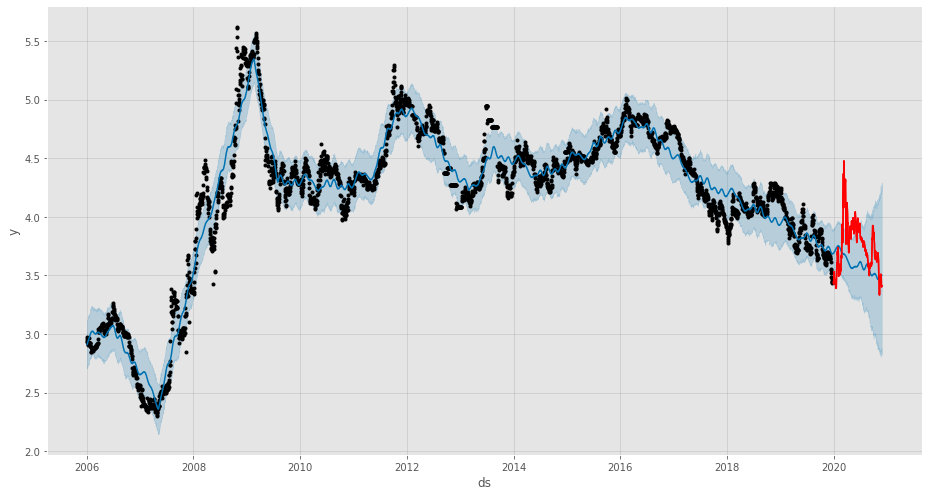

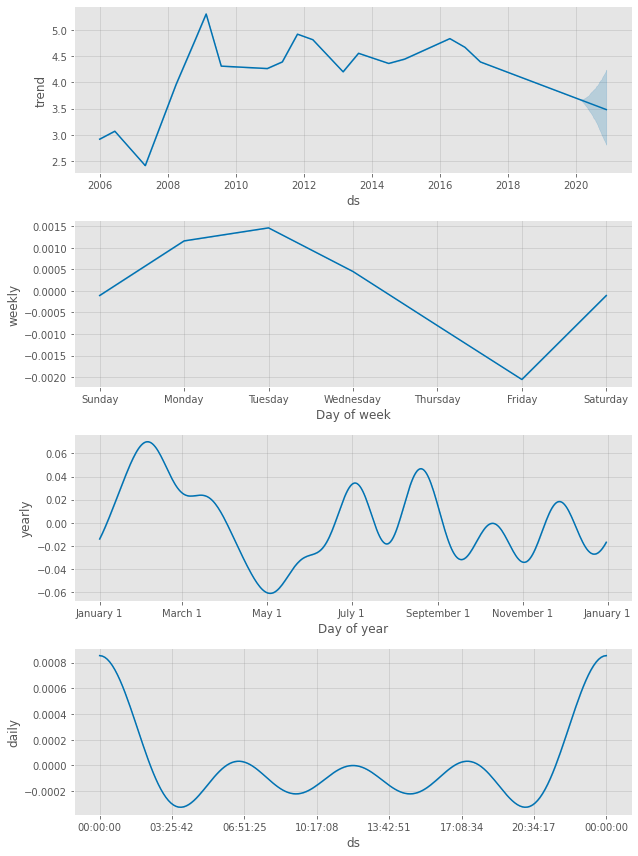

Francia


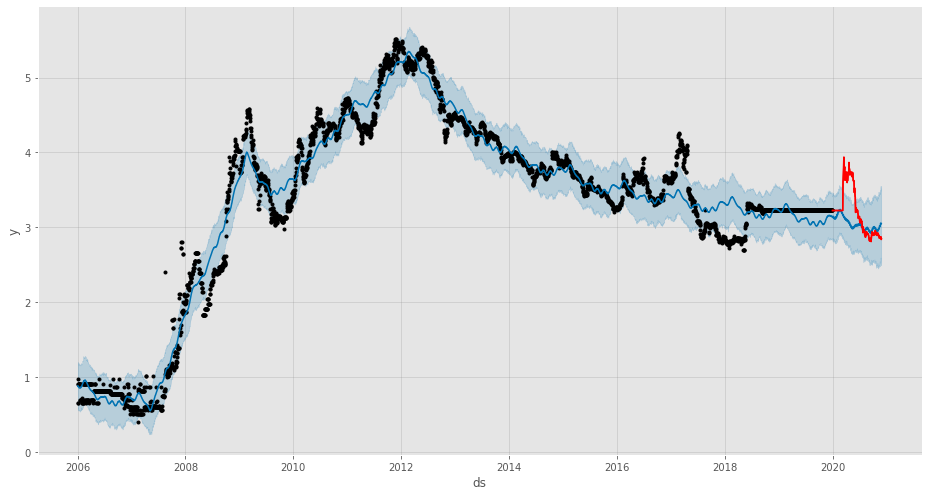

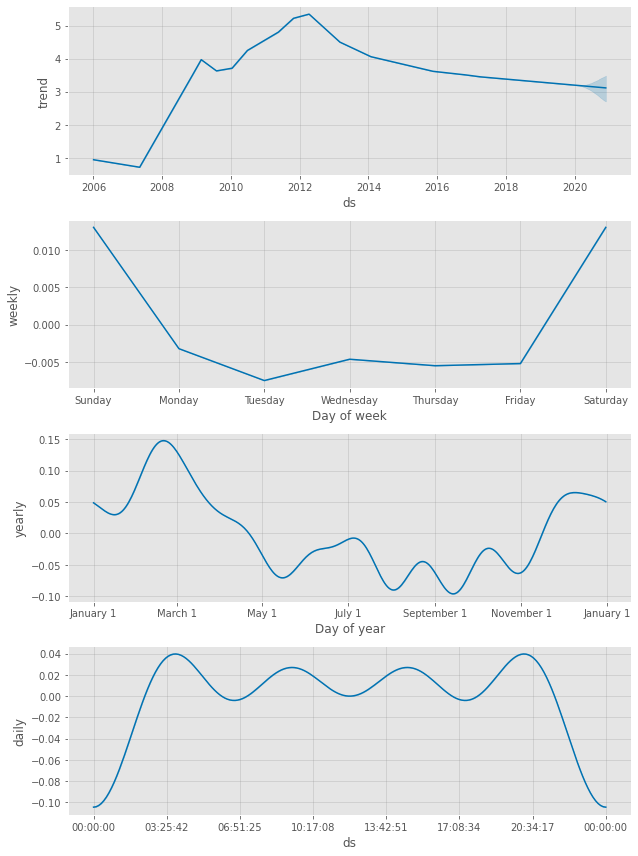

Alemania


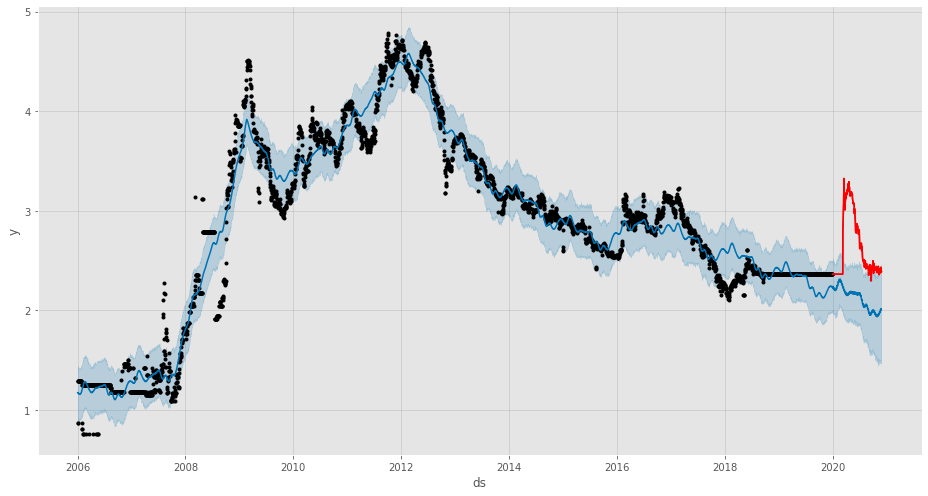

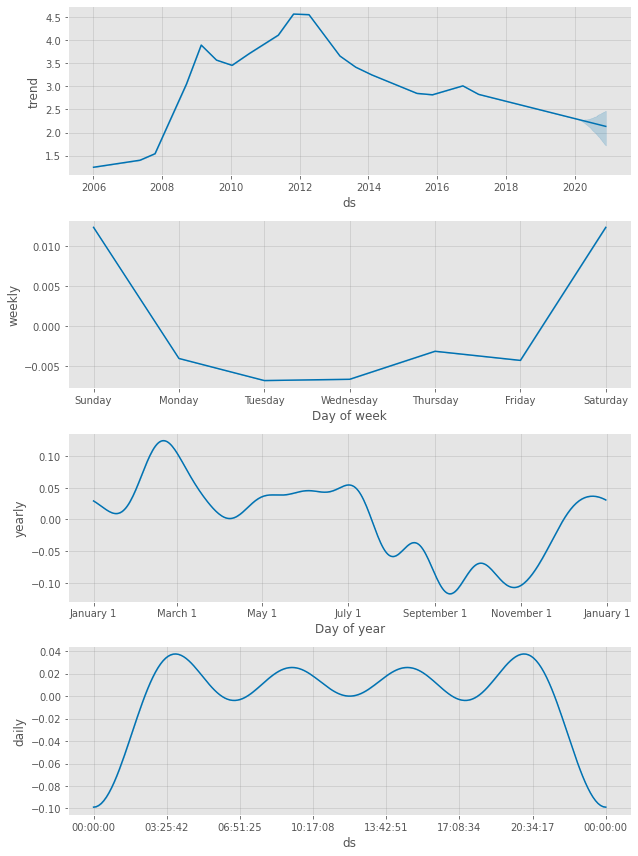

In [ ]:
def prophet(close,start_year='2006',split_year='2019'):
  data = pd.DataFrame(close).copy()
  #split data into train, and test
  prices = data.loc[start_year:str(int(split_year)-1)]
  test_data = data.loc[split_year:]
  #prepare data for the model
  prices['y'] = prices
  prices['ds'] = prices.index
  prices = prices[['ds', 'y']].reset_index()
  test_data['y'] = test_data
  #create a prophet model
  m = Prophet(daily_seasonality=True)
  m.fit(prices)
  #create a dataframe for the future
  periods = (pd.DataFrame(test_data.iloc[-1]).T.index - pd.DataFrame(test_data.iloc[0]).T.index).days[0]
  future = m.make_future_dataframe(periods=periods, freq='D')
  #create forecast
  forecast = m.predict(future)
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
  #create plots
  fig1 = m.plot(forecast, figsize=(13,7))
  plt.plot(test_data,color='red')
  fig2 = m.plot_components(forecast)
  plt.show()
  return forecast

fbprophet = pd.DataFrame
for cds in data.columns:
  print(cds)
  prophet(np.log(data[cds].dropna()),split_year='2020')


##VAR: Vector Autoregressions

https://www.statsmodels.org/dev/vector_ar.html

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

###3.Normalizing data 

(convertion from prices to logarithmic returns)

Starting Date:  2010-01-04
Shape:  (2085, 9)
Colombia CDS Log. Scale Price:


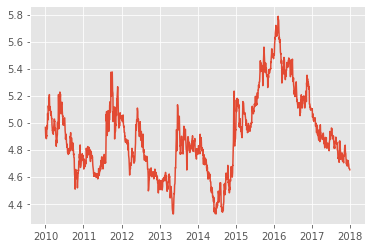

Colombia CDS Log. returns:


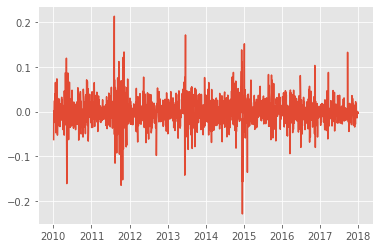

Colombia CDS Log. returns distribution:


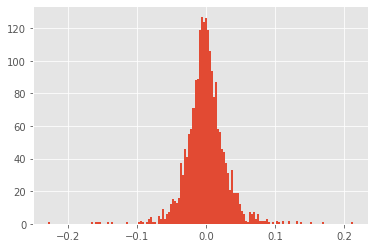

Mexico CDS Log. Scale Price:


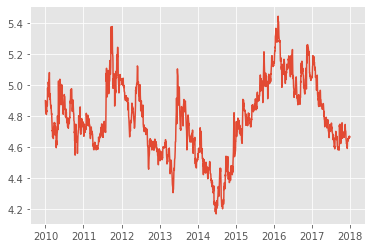

Mexico CDS Log. returns:


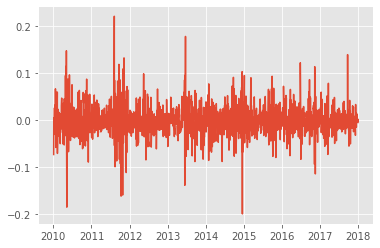

Mexico CDS Log. returns distribution:


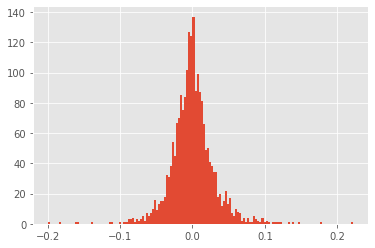

Chile CDS Log. Scale Price:


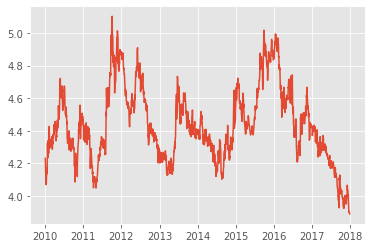

Chile CDS Log. returns:


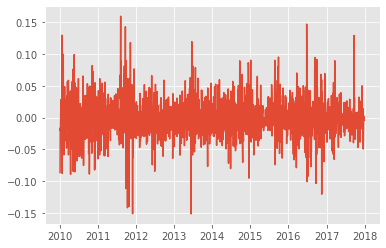

Chile CDS Log. returns distribution:


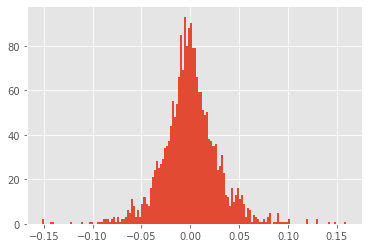

Brasil CDS Log. Scale Price:


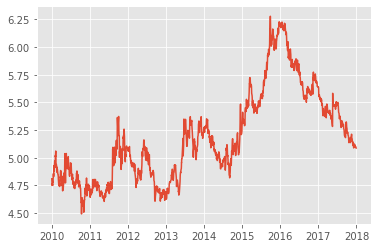

Brasil CDS Log. returns:


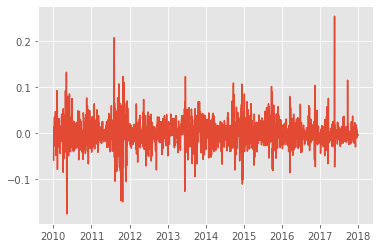

Brasil CDS Log. returns distribution:


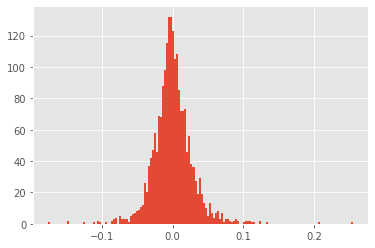

Rusia CDS Log. Scale Price:


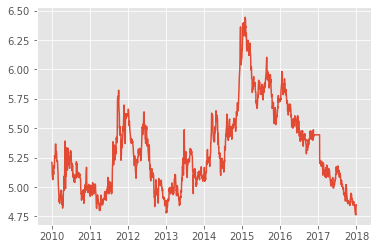

Rusia CDS Log. returns:


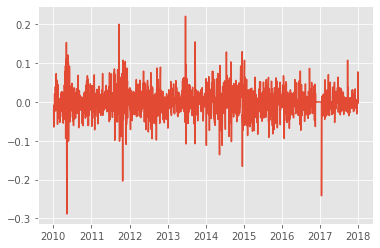

Rusia CDS Log. returns distribution:


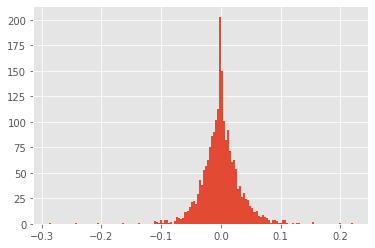

Japon CDS Log. Scale Price:


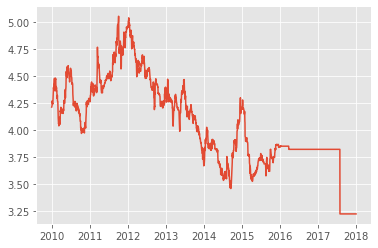

Japon CDS Log. returns:


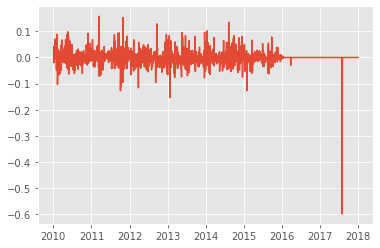

Japon CDS Log. returns distribution:


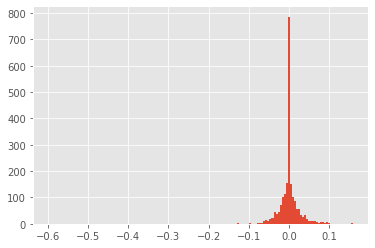

China CDS Log. Scale Price:


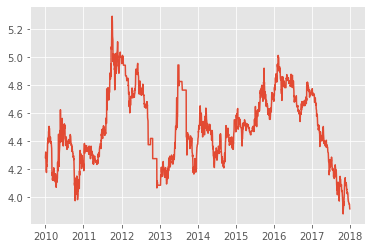

China CDS Log. returns:


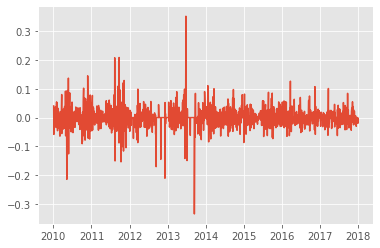

China CDS Log. returns distribution:


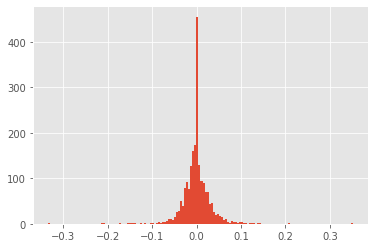

Francia CDS Log. Scale Price:


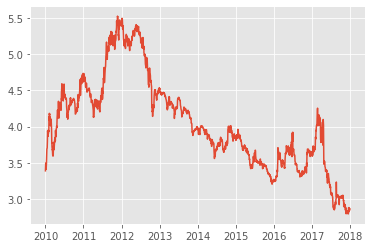

Francia CDS Log. returns:


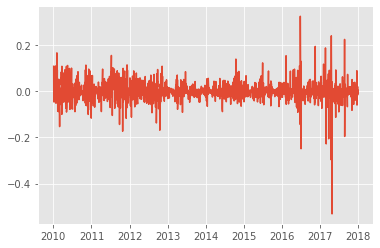

Francia CDS Log. returns distribution:


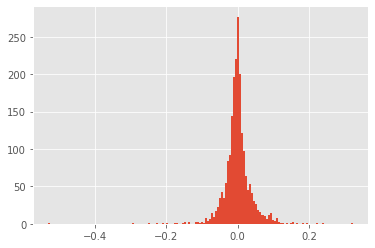

Alemania CDS Log. Scale Price:


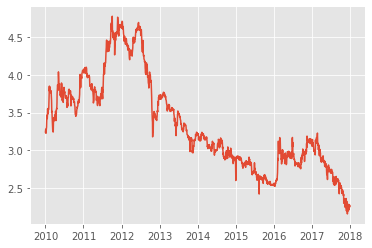

Alemania CDS Log. returns:


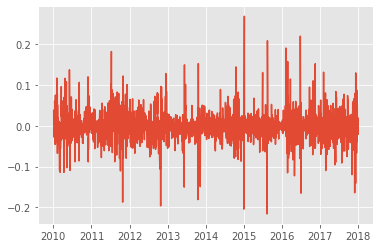

Alemania CDS Log. returns distribution:


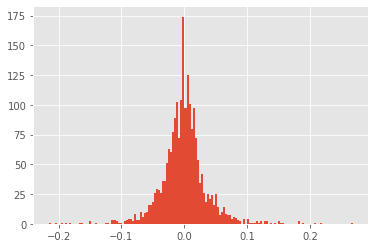

In [ ]:

#creating historicals Logarithmic returns Dataframe based on prices
logreturn_data = np.log(train_data.pct_change()+1).dropna()
log_data = np.log(train_data)    #para utilizar precios logaritmicos en lugar de retornos

#Showing/printing info from CDS's log returns
print('Starting Date: ', str(pd.DataFrame(logreturn_data.iloc[0]).T.index.values[0])[0:10])
print('Shape: ',logreturn_data.shape)
for cds in logreturn_data.columns:
  print(cds, 'CDS Log. Scale Price:')
  plt.plot(log_data[cds])
  plt.show()
  print(cds, 'CDS Log. returns:')
  plt.plot(logreturn_data[cds])
  plt.show()
  print(cds, 'CDS Log. returns distribution:')
  plt.hist(logreturn_data[cds], bins=150)
  plt.show()

###4.Preparing model

In [ ]:
# make a VAR model
model_returns = VAR(logreturn_data)
model_price = VAR(log_data)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency B will be used.



###5.Model results

In [ ]:
results_returns = model_returns.fit(2)
results_returns.summary()

results_price = model_price.fit(2)
results_price.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 02, Dec, 2020
Time:                     16:47:17
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -67.5214
Nobs:                     2084.00    HQIC:                  -67.8147
Log likelihood:           44397.0    FPE:                2.98396e-30
AIC:                     -67.9843    Det(Omega_mle):     2.74992e-30
--------------------------------------------------------------------
Results for equation Colombia
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.036939         0.017103            2.160           0.031
L1.Colombia         0.920156         0.057266           16.068           0.000
L1.Mexico           0.193919         0.055045            3.523   

In [ ]:
results_returns.plot()
results_price.plot()

In [ ]:
results_returns.plot_acorr()

In [ ]:
model_returns.select_order(15)
results_returns = model_returns.fit(maxlags=30, ic='aic')

model_price.select_order(15)
results_price = model_price.fit(maxlags=30, ic='aic')

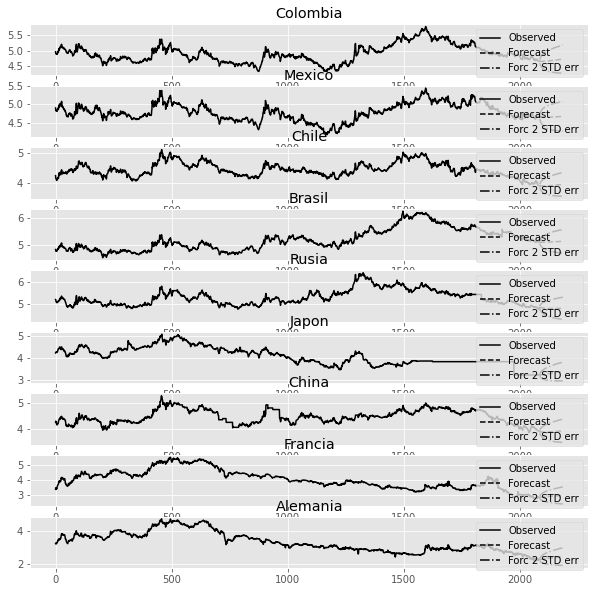

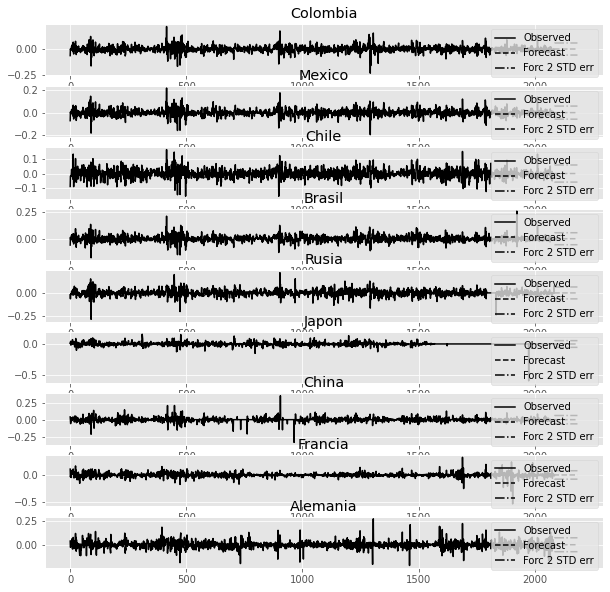

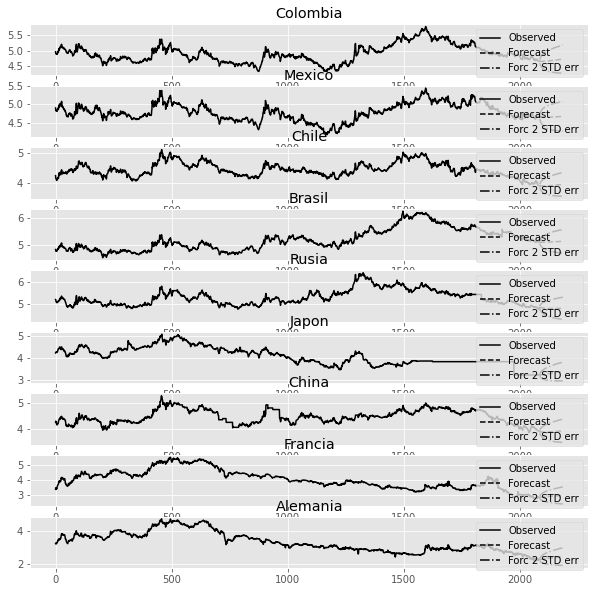

In [ ]:
lag_order = results_returns.k_ar
results_returns.forecast(logreturn_data.values[-lag_order:], 100)
results_returns.plot_forecast(100)

lag_order = results_price.k_ar
results_price.forecast(log_data.values[-lag_order:], 100)
results_price.plot_forecast(100)

In [ ]:
forecast_periods = 30

forecast_returns = pd.DataFrame(results_returns.forecast(logreturn_data.values[-lag_order:], forecast_periods),columns=CDS_list)
forecast_returns_complete = pd.concat([logreturn_data,forecast_returns], ignore_index=True)
forecast_returns_complete = np.exp(forecast_returns_complete)
forecast_returns_complete = pd.concat([pd.DataFrame(train_data.iloc[0]).T,forecast_returns_complete], ignore_index=True).cumprod()

forecast_logprice = pd.DataFrame(results_price.forecast(log_data.values[-lag_order:], forecast_periods),columns=CDS_list)
forecast_logprice_complete = pd.concat([log_data,forecast_logprice], ignore_index=True)
forecast_price_complete = np.exp(forecast_logprice_complete)

(2116, 9)
Colombia  CDS: Forecast based on Price


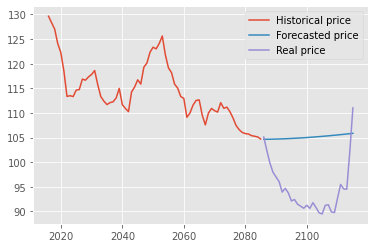

Colombia  CDS: Forecast based on Returns


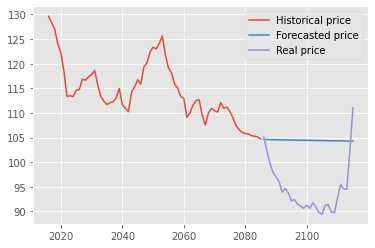

Mexico  CDS: Forecast based on Price


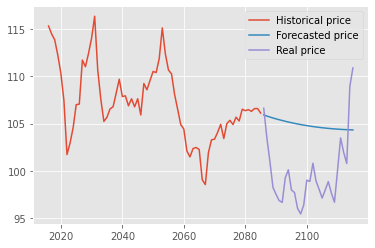

Mexico  CDS: Forecast based on Returns


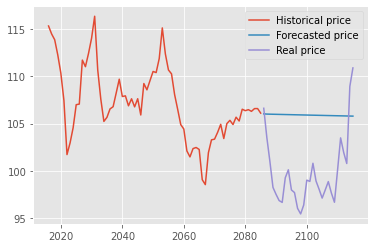

Chile  CDS: Forecast based on Price


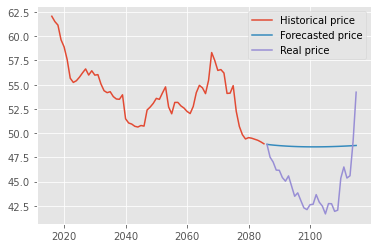

Chile  CDS: Forecast based on Returns


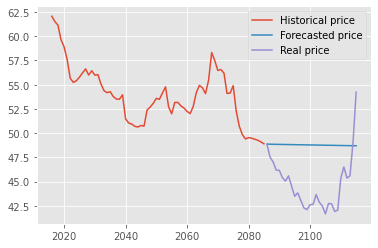

Brasil  CDS: Forecast based on Price


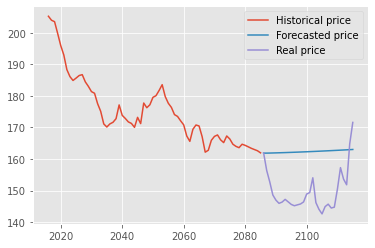

Brasil  CDS: Forecast based on Returns


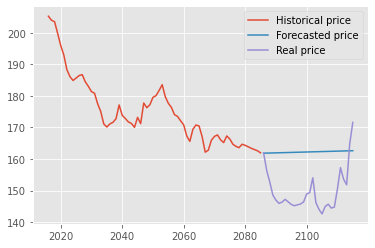

Rusia  CDS: Forecast based on Price


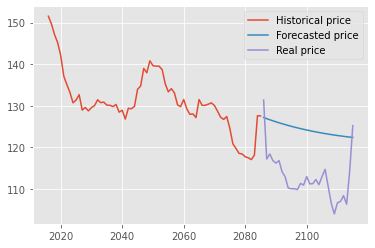

Rusia  CDS: Forecast based on Returns


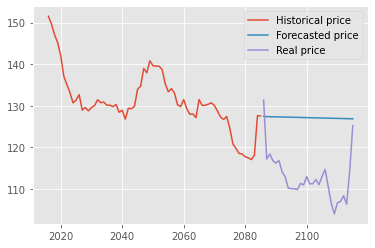

Japon  CDS: Forecast based on Price


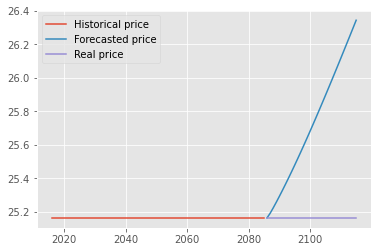

Japon  CDS: Forecast based on Returns


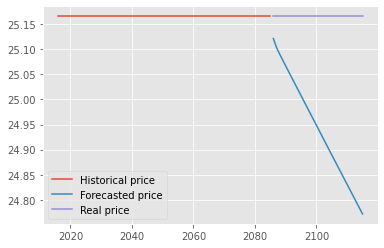

China  CDS: Forecast based on Price


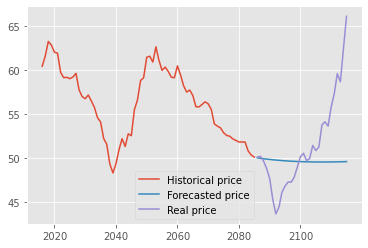

China  CDS: Forecast based on Returns


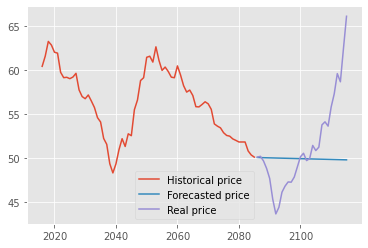

Francia  CDS: Forecast based on Price


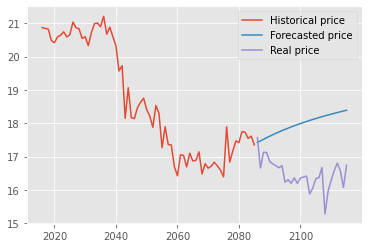

Francia  CDS: Forecast based on Returns


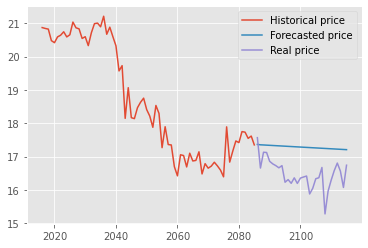

Alemania  CDS: Forecast based on Price


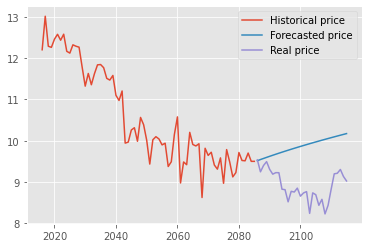

Alemania  CDS: Forecast based on Returns


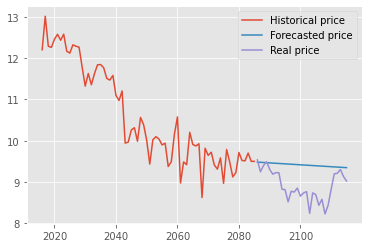

In [ ]:
historical_periods_plot = 100

print(forecast_price_complete.shape)
for cds in forecast_price_complete.columns:
  print(cds, ' CDS: Forecast based on Price')
  plt.plot(forecast_price_complete[cds].iloc[(historical_periods_plot*(-1)):(forecast_periods*(-1))],label='Historical price')
  plt.plot(forecast_price_complete[cds].iloc[(forecast_periods*(-1)):],label='Forecasted price')
  test_data[cds].index = np.arange(forecast_price_complete[cds].iloc[(forecast_periods*(-1)):].index.start, len(test_data[cds].index) + forecast_price_complete[cds].iloc[(forecast_periods*(-1)):].index.start)
  plt.plot(test_data[cds].iloc[0:forecast_periods],label='Real price')
  plt.legend()
  plt.show()
  print(cds, ' CDS: Forecast based on Returns')
  plt.plot(forecast_returns_complete[cds].iloc[(historical_periods_plot*(-1)):(forecast_periods*(-1))],label='Historical price')
  plt.plot(forecast_returns_complete[cds].iloc[(forecast_periods*(-1)):],label='Forecasted price')
  test_data[cds].index = np.arange(forecast_returns_complete[cds].iloc[(forecast_periods*(-1)):].index.start, len(test_data[cds].index) + forecast_returns_complete[cds].iloc[(forecast_periods*(-1)):].index.start)
  plt.plot(test_data[cds].iloc[0:forecast_periods],label='Real price')
  plt.legend()
  plt.show()

##Redes LSTM

link: https://youtu.be/3kXj6VgxbP8

In [ ]:
np.random.seed(4)
import datetime 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(train_data)


In [ ]:

# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento

time_step = 7
dias_pronostico = time_step

def XY_train(set_escalado, time_step=time_step, dias_pronostico=dias_pronostico):
  X_train = []
  Y_train = []
  for i in range(time_step,len(set_escalado)-dias_pronostico):
      # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
      X_train.append(set_escalado[i-time_step:i])
      # Y: el siguiente dato
      Y_train.append(set_escalado[i:i+dias_pronostico])
  return np.array(X_train), np.array(Y_train)

X_train, Y_train = XY_train(set_entrenamiento_escalado)

In [ ]:
# Reshape X_train para que se ajuste al modelo en Keras
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],X_train.shape[2], 1))

In [ ]:
# Red LSTM

def train_lstm(X_train, Y_train, na = 50,epochs = 15,batch_size = 32):
  dim_entrada = (X_train.shape[1:])
  #dim_salida = Y_train.shape[1], Y_train.shape[2]
  modelo = Sequential()
  modelo.add(LSTM(units=na, input_shape=dim_entrada, return_sequences = True))
  modelo.add(Dense(units=Y_train.shape[2]))#, input_shape=X_train.shape[:]))
  modelo.compile(optimizer='rmsprop', loss='mse')
  modelo.fit(X_train,Y_train,epochs=epochs,batch_size=batch_size)
  return modelo

modelo = train_lstm(X_train,Y_train)

Epoch 1/15
109/109 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 2/15
109/109 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 3/15
109/109 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 4/15
109/109 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 5/15
109/109 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 6/15
109/109 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 7/15
109/109 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 8/15
109/109 [==============================] - 1s 5ms/step - loss: 0.0016
Epoch 9/15
109/109 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 10/15
109/109 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 11/15
109/109 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 12/15
109/109 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 13/15
109/109 [====

In [ ]:
# Validación (predicción del valor de las acciones)
# 

X_test = []
for i in range(len(set_entrenamiento_escalado)-dias_pronostico, len(set_entrenamiento_escalado)):
    X_test.append(set_entrenamiento_escalado[i-time_step:i])
X_test = np.array(X_test)

predicciones = modelo.predict(X_test)
prediccion = sc.inverse_transform(predicciones[-1][::-1])

Colombia


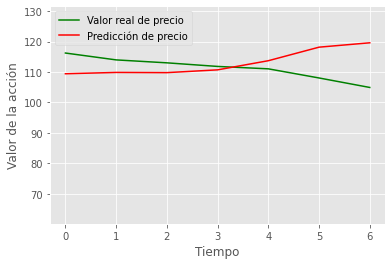

Mexico


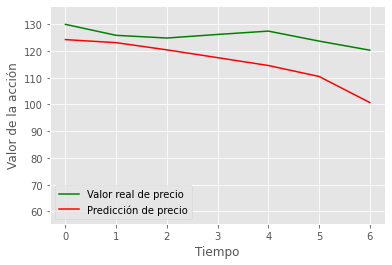

Chile


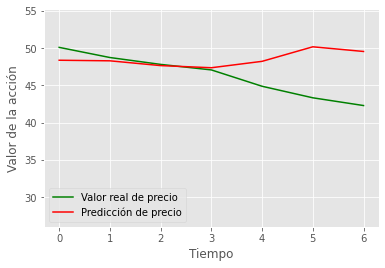

Brasil


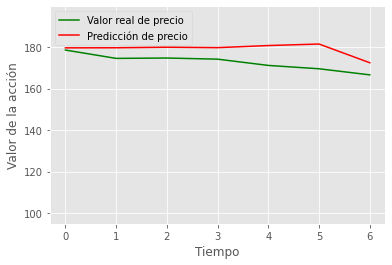

Rusia


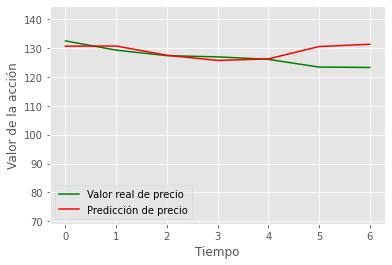

Japon


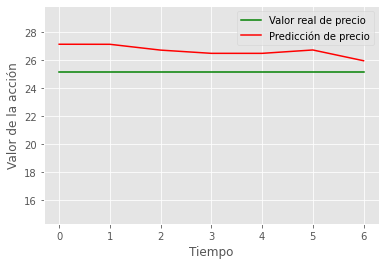

China


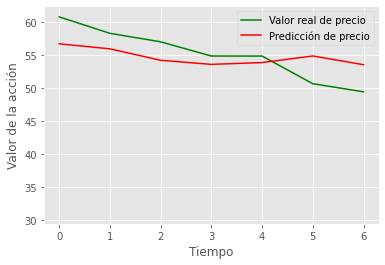

Francia


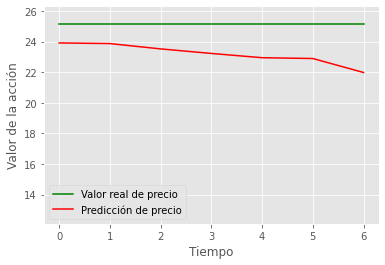

Alemania


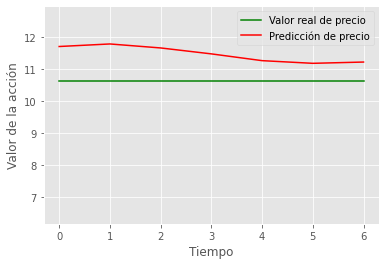

In [ ]:
# Funcion auxiliar
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='g', label='Valor real de precio')
    plt.plot(prediccion, color='red', label='Predicción de precio')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

# Graficar resultados
for i in range(0,len(test_data.columns)):
  print(data.columns[i])
  graficar_predicciones(test_data.values[:,i],prediccion[:,i])

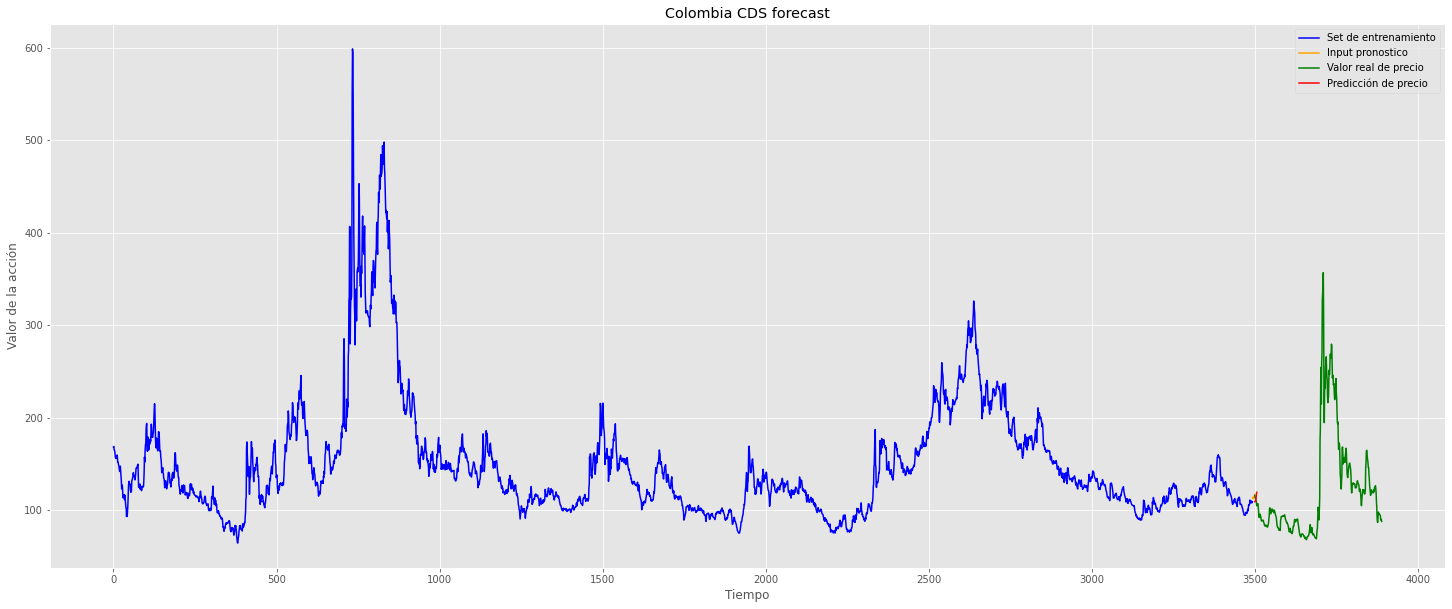

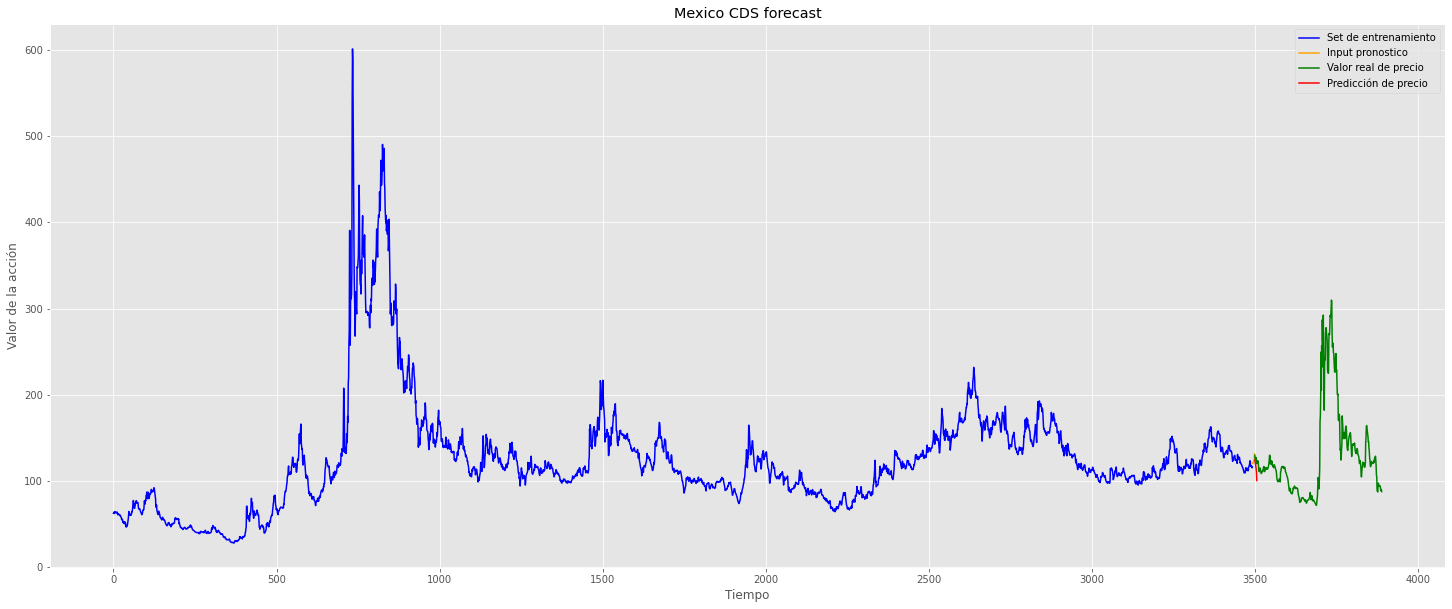

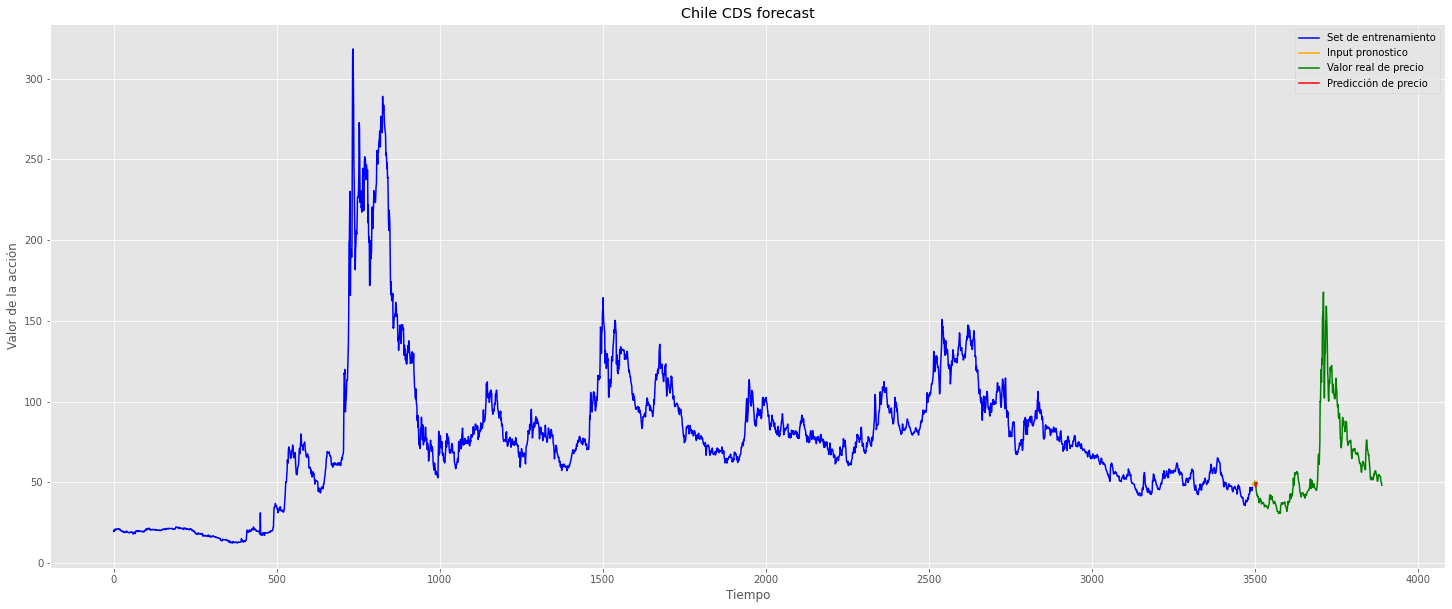

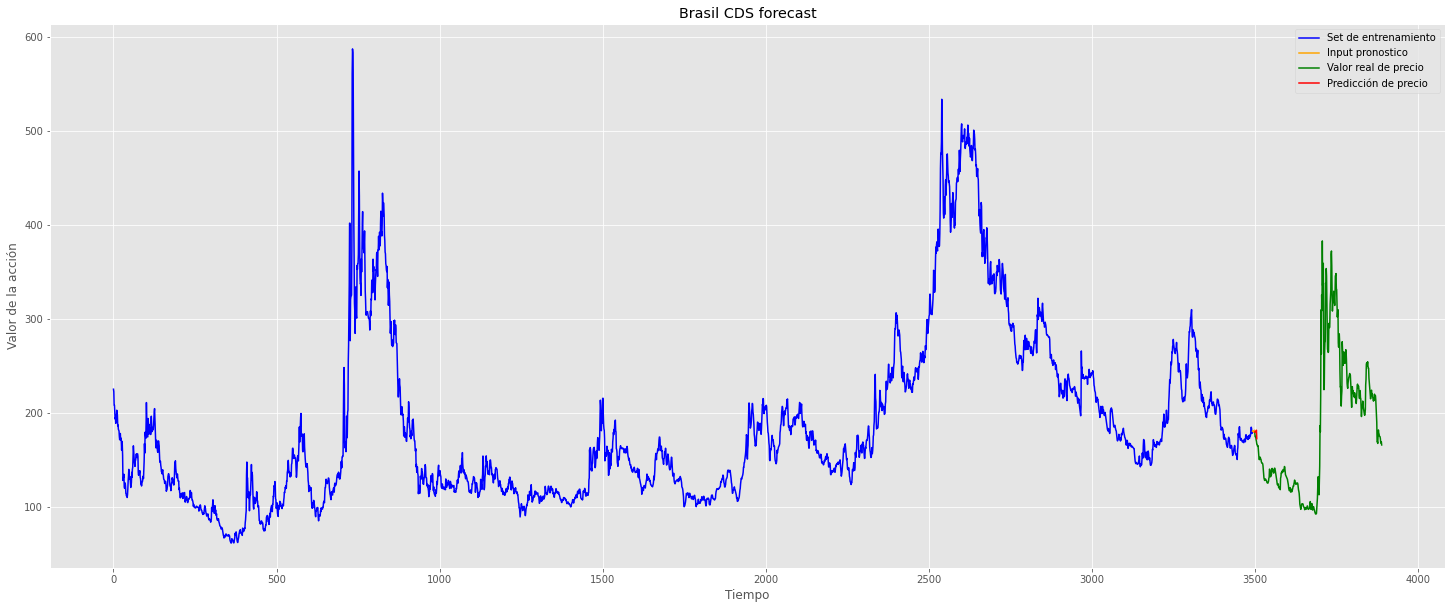

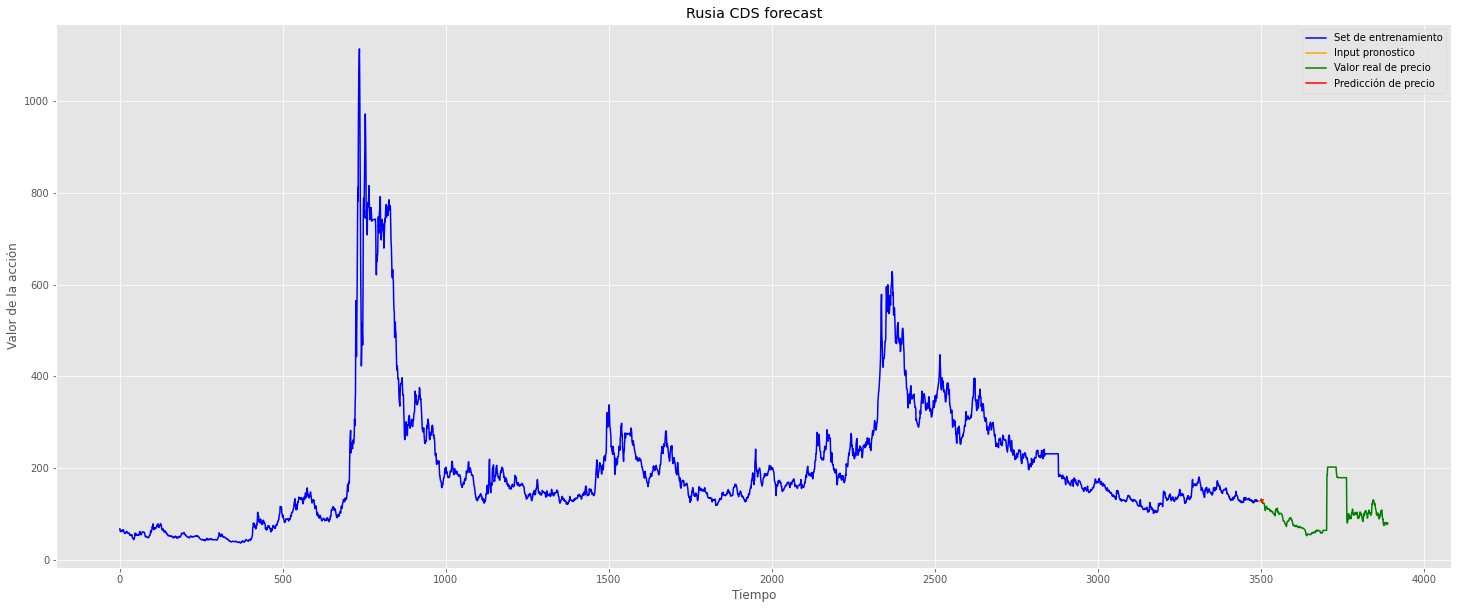

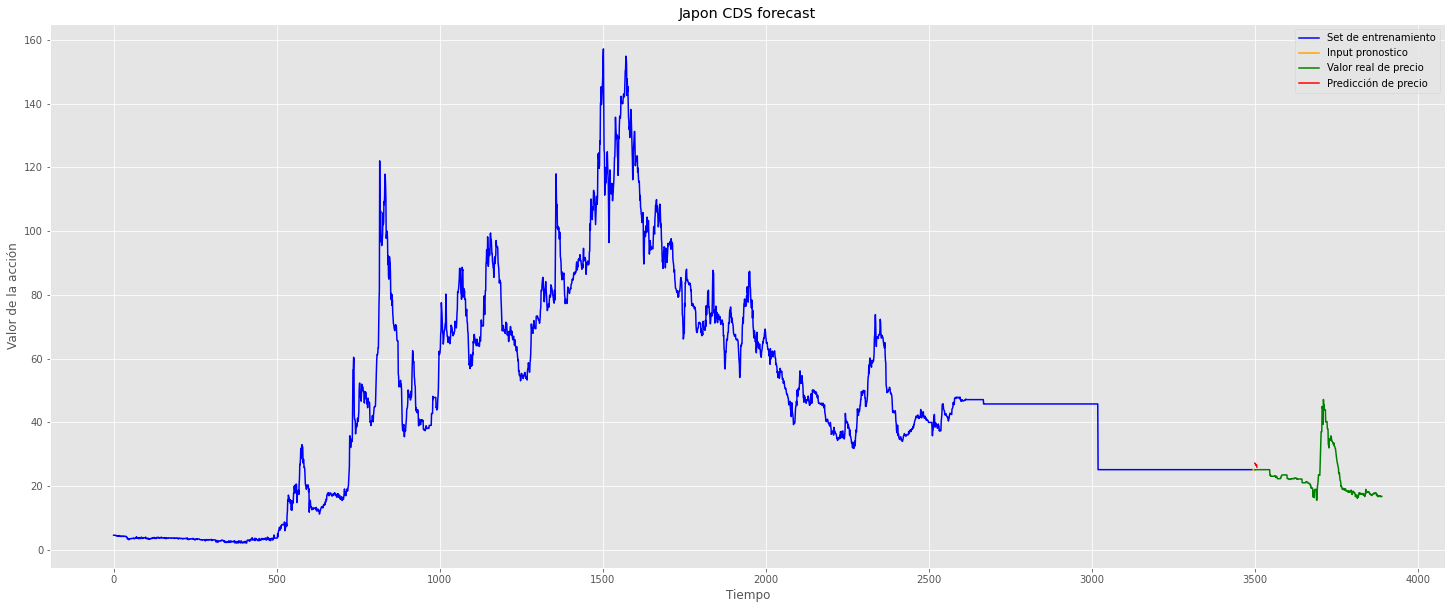

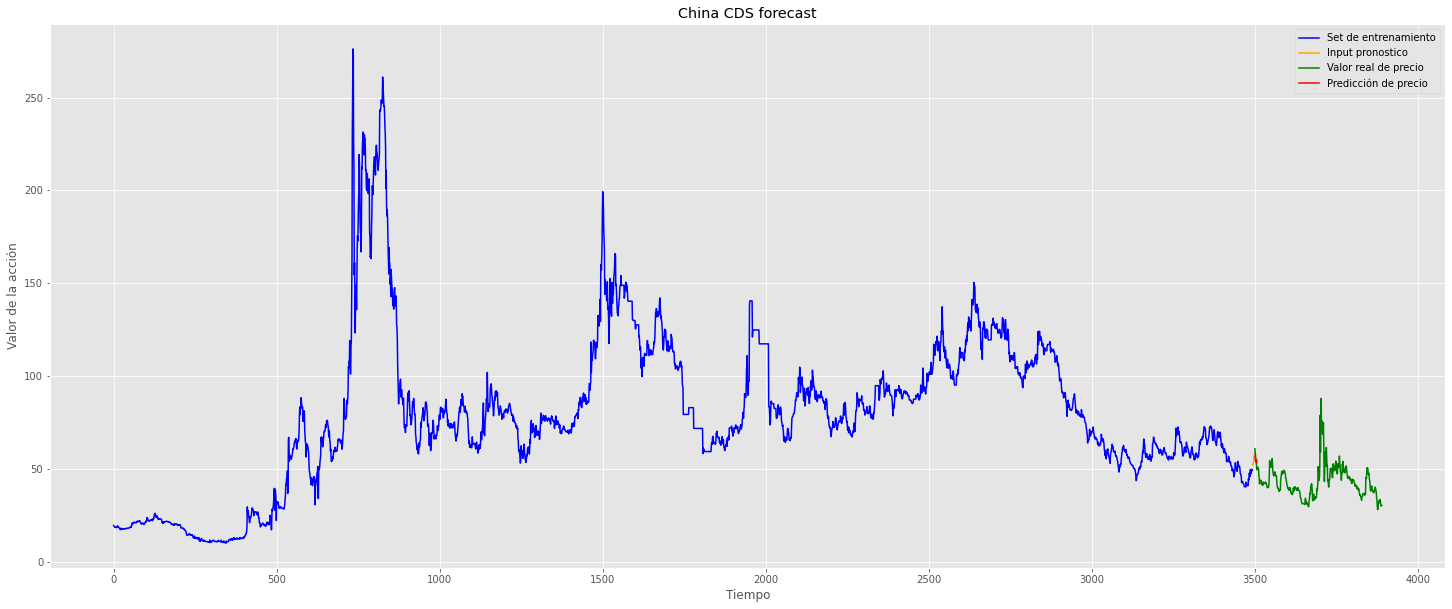

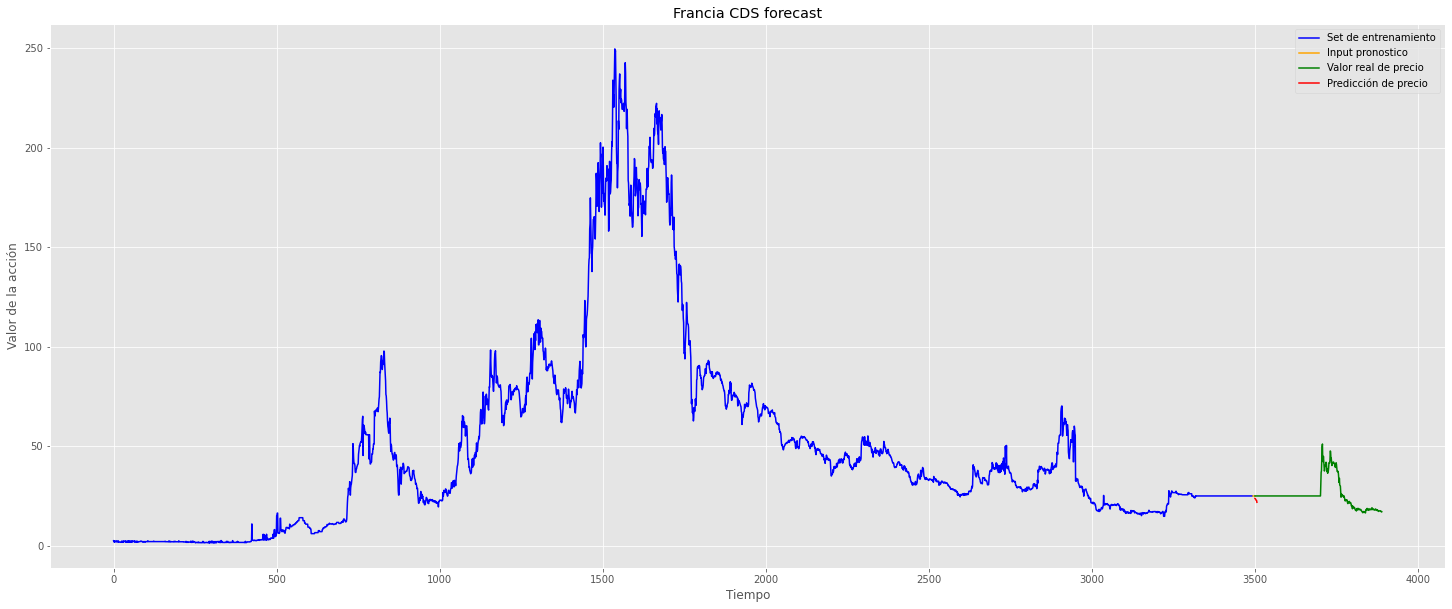

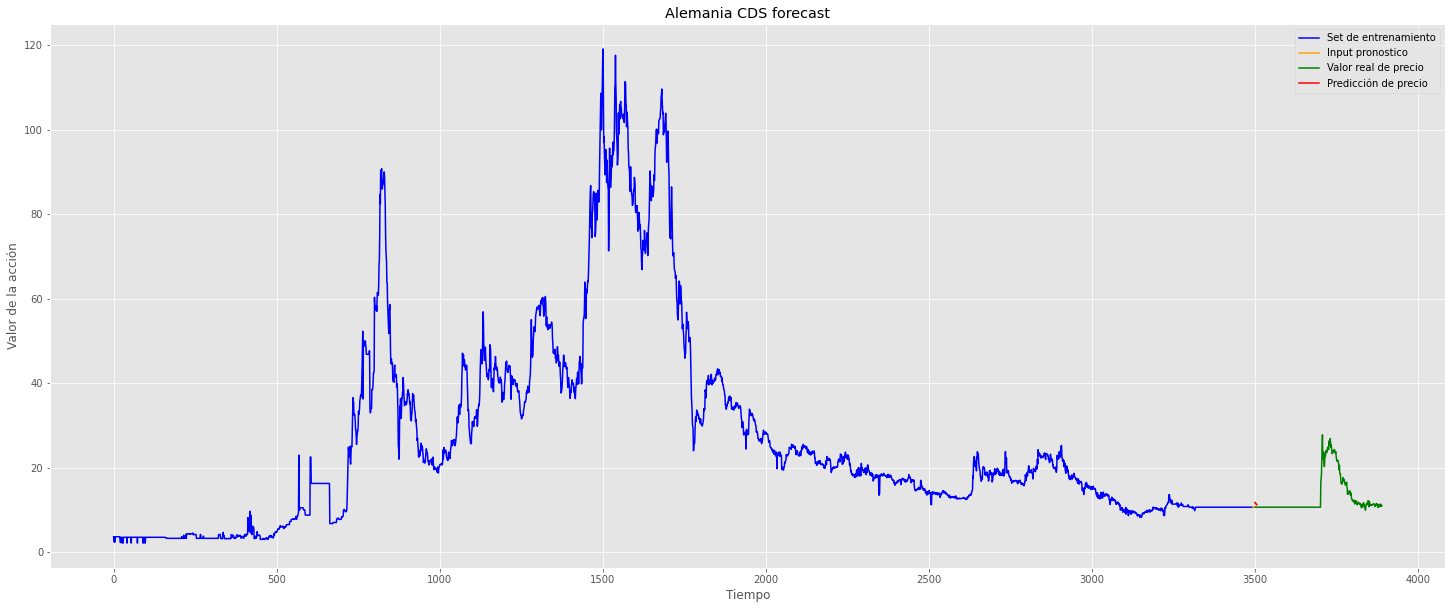

In [ ]:
for i in range(0,len(test_data.columns)):
  n1 = len(train_data.values)
  n2 = len(test_data.values)
  n3 = len(prediccion)+time_step
  # Graficar resultados
  fig = plt.figure(figsize=(25,10))
  fig.tight_layout()
  plt.plot(train_data.values[:(dias_pronostico*-1),i],color='blue', label='Set de entrenamiento')
  plt.plot(range(n1-dias_pronostico, n1, 1), train_data.values[(dias_pronostico*-1):,i],color='orange', label='Input pronostico')
  plt.plot(range(n1, n1+n2, 1), test_data.values[:,i],color='g', label='Valor real de precio')
  #plt.plot(range(n1+time_step+(dias_pronostico-1), n1+n3+(dias_pronostico-1), 1), prediccion[:,i],color='red' , label='Predicción de precio')
  plt.plot(range(n1, n1+len(prediccion), 1), prediccion[:,i],color='red' , label='Predicción de precio')
  plt.xlabel('Tiempo')
  plt.ylabel('Valor de la acción')
  plt.title(data.columns[i] + ' CDS forecast')
  plt.legend()
  plt.show()

# Evaluación de Resultados

 ***Forecast Error***

 https://youtu.be/19sULW0Bidw

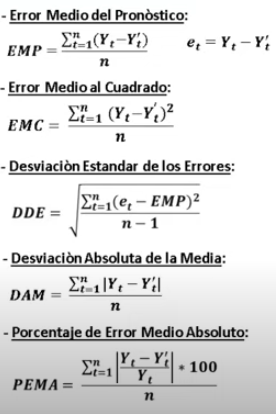

### LSTM:

EMP: Error Medio de Pronostico

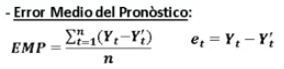

In [ ]:
EMP_LSTM = {}
for i in range(0,len(data.columns)):
  EMP_LSTM[data.columns[i]] = []
  for row in range(0,len(prediccion)):
    EMP_LSTM[data.columns[i]].append(test_data.values[row,i] - prediccion[row,i])
  EMP_LSTM[data.columns[i]] = sum(EMP_LSTM[data.columns[i]])/len(EMP_LSTM[data.columns[i]])
  print(data.columns[i] +': Error Medio de Pronóstico: ', EMP_LSTM[data.columns[i]])

Colombia: Error Medio de Pronóstico:  -1.7398689836774537
Mexico: Error Medio de Pronóstico:  9.591395664760046
Chile: Error Medio de Pronóstico:  -2.1977171238490527
Brasil: Error Medio de Pronóstico:  -6.32566735839844
Rusia: Error Medio de Pronóstico:  -1.9670194876534595
Japon: Error Medio de Pronóstico:  -1.5052346758161268
China: Error Medio de Pronóstico:  0.4535034659249441
Francia: Error Medio de Pronóstico:  1.9733272792271197
Alemania: Error Medio de Pronóstico:  -0.8490363529750279


EMC: Error Medio al Cuadrado

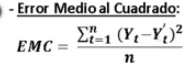

In [ ]:
EMC_LSTM = {}
for i in range(0,len(data.columns)):
  EMC_LSTM[data.columns[i]] = []
  for row in range(0,len(prediccion)):
    EMC_LSTM[data.columns[i]].append((test_data.values[row,i] - prediccion[row,i])**2)
  EMC_LSTM[data.columns[i]] = sum(EMC_LSTM[data.columns[i]])/len(EMC_LSTM[data.columns[i]])
  print(data.columns[i] +': Error Medio al Cuadrado: ', EMC_LSTM[data.columns[i]])

Colombia: Error Medio al Cuadrado:  56.98931066818511
Mexico: Error Medio al Cuadrado:  122.39824605285821
Chile: Error Medio al Cuadrado:  16.229625069012833
Brasil: Error Medio al Cuadrado:  50.468851815463445
Rusia: Error Medio al Cuadrado:  17.39492428482199
Japon: Error Medio al Cuadrado:  2.4107882525984476
China: Error Medio al Cuadrado:  9.591373596749538
Francia: Error Medio al Cuadrado:  4.280467681514267
Alemania: Error Medio al Cuadrado:  0.7755845639325604


DDE: Desviación Estandar de los Errores

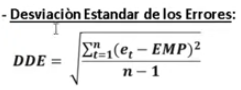

In [ ]:
DDE_LSTM = {}
for i in range(0,len(data.columns)):
  DDE_LSTM[data.columns[i]] = []
  for row in range(0,len(prediccion)):
    DDE_LSTM[data.columns[i]].append(((test_data.values[row,i] - prediccion[row,i]) - EMP_LSTM[data.columns[i]]) **2)
  DDE_LSTM[data.columns[i]] = np.sqrt(sum(DDE_LSTM[data.columns[i]])/len(DDE_LSTM[data.columns[i]])-1)
  print(data.columns[i] + ': Desviación Estándar de los Errores: ', DDE_LSTM[data.columns[i]])

Colombia: Desviación Estándar de los Errores:  7.277511015987699
Mexico: Desviación Estándar de los Errores:  5.422487921137343
Chile: Desviación Estándar de los Errores:  3.2248510837794484
Brasil: Desviación Estándar de los Errores:  3.0748632955557467
Rusia: Desviación Estándar de los Errores:  3.539174850161194
Japon: Desviación Estándar de los Errores:  nan
China: Desviación Estándar de los Errores:  2.8958087304142865
Francia: Desviación Estándar de los Errores:  nan
Alemania: Desviación Estándar de los Errores:  nan


DAM: Desviación Absoluta de la Media

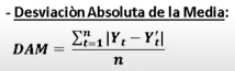

In [ ]:
DAM_LSTM = {}
for i in range(0,len(data.columns)):
  DAM_LSTM[data.columns[i]] = []
  for row in range(0,len(prediccion)):
    DAM_LSTM[data.columns[i]].append(abs(test_data.values[row,i] - prediccion[row,i]))
  DAM_LSTM[data.columns[i]] = sum(DAM_LSTM[data.columns[i]])/len(DAM_LSTM[data.columns[i]])
  print(data.columns[i] + ': Desviación Absoluta de la Media: ', DAM_LSTM[data.columns[i]])

Colombia: Desviación Absoluta de la Media:  6.098004185267856
Mexico: Desviación Absoluta de la Media:  9.591395664760046
Chile: Desviación Absoluta de la Media:  2.8621656014578676
Brasil: Desviación Absoluta de la Media:  6.32566735839844
Rusia: Desviación Absoluta de la Media:  2.843562805175781
Japon: Desviación Absoluta de la Media:  1.5052346758161268
China: Desviación Absoluta de la Media:  2.827606719970704
Francia: Desviación Absoluta de la Media:  1.9733272792271197
Alemania: Desviación Absoluta de la Media:  0.8490363529750279


PEMA: Porcentaje de Error Medio Absoluto

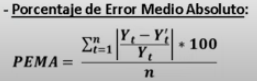

In [ ]:
PEMA_LSTM = {}
for i in range(0,len(data.columns)):
  PEMA_LSTM[data.columns[i]] = []
  for row in range(0,len(prediccion)):
    PEMA_LSTM[data.columns[i]].append(abs((test_data.values[row,i] - prediccion[row,i]) / test_data.values[row,i])*100)
  PEMA_LSTM[data.columns[i]] = round(sum(PEMA_LSTM[data.columns[i]])/len(PEMA_LSTM[data.columns[i]]),2)
  print(data.columns[i] + ': Porcentaje de Error Medio Absoluto: ' + str(PEMA_LSTM[data.columns[i]]) + '%')

Colombia: Porcentaje de Error Medio Absoluto: 5.58%
Mexico: Porcentaje de Error Medio Absoluto: 7.71%
Chile: Porcentaje de Error Medio Absoluto: 6.52%
Brasil: Porcentaje de Error Medio Absoluto: 3.69%
Rusia: Porcentaje de Error Medio Absoluto: 2.28%
Japon: Porcentaje de Error Medio Absoluto: 5.98%
China: Porcentaje de Error Medio Absoluto: 5.19%
Francia: Porcentaje de Error Medio Absoluto: 7.84%
Alemania: Porcentaje de Error Medio Absoluto: 7.99%
